In [140]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase
from data_analytics import parse_madlib_line, parse_ctq_line, parse_standalone_line, split_standalone_line
import numpy as np
import pandas as pd
from data_analytics import save_fig
from data_analytics import TIME_FORMAT
from data_analytics import readlines
import seaborn as sns
import matplotlib
import datetime
import glob
import os
import re
import dill
import ast
from collections import defaultdict
from collections import OrderedDict
font = {'family': 'normal', 'size': 16}
matplotlib.rc('font', **font)

matplotlib.rcParams.update({'font.size': 16})


# Between-Start MOP training epoch-1 subepoch-0-End fit_transition training
def parse_ddp_line(line):
    info_lst, time_obj, timestamp = parse_ctq_line(line, return_timestamp=True)
    info = ': '.join(info_lst)
    for keyword in ["loading data", "MST"]:
        for prefix in ['Start', 'End']:
            pattern = "{} {}".format(prefix, keyword)
            if pattern in info:
                info = pattern
    return info, time_obj, timestamp


def parse_events(lines, method):
    events = []
    if method == 'standalone':
        parse = parse_standalone_line
    elif method == 'ddp':
        parse = parse_ddp_line
    else:
        parse = parse_madlib_line
    parsed = [parse(line) for line in lines]
    #     parsed = sorted(parsed, key=lambda x: x[0], reverse=True)
    parsed = sorted(parsed, key=lambda x: x[1])
    info1, time_obj1, _ = parsed[0]
    for parsed_line in parsed[1:]:
        info2, time_obj2, _ = parsed_line
        event = "Between-{}-{}".format(info1, info2)
        time_diff = (time_obj2 - time_obj1).total_seconds()
        events.append({'event': event, 'time': time_diff})
        info1, time_obj1 = info2, time_obj2
    df_events = pd.DataFrame(events)
    return df_events


def parse_all_events(la, segs=None, method=None):
    if not segs:
        if method == 'ddp':
            segs = [0]
        else:
            segs = range(8)
    df_events_list = []
    for i in segs:
        if method == 'ddp':
            lines = readlines(os.path.join(la.exp_root, 'worker0.log'))
            global_lines = readlines(os.path.join(la.exp_root,
                                                  '../global.log'))
            start_line = "Start exp: " + global_lines[0].split('time ')[-1]
            end_line = "End exp: " + global_lines[-2].split('time ')[-1]
            lines_filtered = [start_line]
            for line in lines:
                if any([x for x in ['End', 'Start'] if x in line]):
                    lines_filtered.append(line)
            lines_filtered.append(end_line)
        else:
            try:
                lines = readlines(os.path.join(la.exp_root, 'client.log'))
            except:
                lines = readlines(os.path.join(la.exp_root, 'scheduler.log'))
            lines_filtered = []
            if method != 'standalone':
                for x in lines:
                    if x != '':
                        if 'seg{}'.format(i) in x:
                            lines_filtered.append(x)
    #                     elif 'seg' not in x and method == 'udaf' and 'End MOP' in x and 'INFO: ' in x:
    #                         lines_filtered.append(x)
            else:
                lines_filtered = lines_filtered = [
                    x for x in lines if x != '' and 'WORKER: {}'.format(i) in x
                ]
        lines = lines_filtered
        df_events = parse_events(lines, method)
        df_events_list.append(df_events)
    df_events_grand = pd.concat(df_events_list, ignore_index=True)
    return df_events_grand


class FakeLA:
    def __init__(self, exp_root):
        self.exp_root = exp_root


def get_plot_time(la, segs, semantics, method, debug=False):
    df_events_grand = parse_all_events(la, segs, method)
    df_propotion_time = df_events_grand.groupby('event').agg(
        'sum').reset_index()[['event', 'time']]
    dict_time = dict(df_propotion_time.to_dict(orient='split')['data'])
    plot_time = {}
    if debug:
        print(dict_time)
        return
    for k, v in dict_time.items():
        scheme = semantics[k]
        if scheme in plot_time:
            plot_time[scheme] += v
        else:
            plot_time[scheme] = v
    return plot_time, dict_time


methods_dict = OrderedDict({
    'Cerebro-Spark': 'spark',
    'MA': 'ma',
    'UDAF': 'udaf',
    'CTQ': 'ctq',
    'DA-Cerebro': 'da',
    'PyTDDP': 'ddp',
    'DA-PyTDDP': 'da-ddp'
})
methods = methods_dict.keys()
e2e_methods_dict = {
    'ma': 'MA',
    'udaf': 'UDAF',
    'ctq': 'CTQ',
    'da': 'DA-Cerebro',
    'filesystem': 'Cerebro-Spark',
    'ddp': 'PyTDDP',
    'da-ddp': 'DA-PyTDDP'
}
e2e_methods_dict_reverse = {v: k for k, v in e2e_methods_dict.items()}

ordered_methods_indices = [methods_dict[x] for x in methods]
INITILAIZATION = 'initialization'
NONE = 'None'
EXITING = 'exiting'
DATA_TRANSMISSION = 'data_transmission'
IDLE = 'idle'
TRAIN_VALID = 'train_valid'
MOP = 'model_hopping'
MERGE = 'merge'
FINAL = 'final'
semantics = {
    'ctq': {
        'Between-End fit_transition clearing-End inside fit_transition':
        EXITING,
        'Between-End fit_transition initialization-Start fit_transition training':
        INITILAIZATION,
        'Between-End fit_transition model hopping-End fit_transition initialization':
        INITILAIZATION,
        'Between-End fit_transition training-Start fit_transition clearing':
        EXITING,
        'Between-End inside fit_transition-Start inside fit_transition':
        DATA_TRANSMISSION,
        'Between-End inside fit_transition-Start inside internal_keras_eval_transition':
        IDLE,
        'Between-End inside internal_keras_eval_transition-Start inside fit_transition':
        IDLE,
        'Between-End inside internal_keras_eval_transition-Start inside internal_keras_eval_transition':
        DATA_TRANSMISSION,
        'Between-End internal_keras_eval_transition evaluate-End inside internal_keras_eval_transition':
        EXITING,
        'Between-End internal_keras_eval_transition initialization-Start internal_keras_eval_transition evaluate':
        INITILAIZATION,
        'Between-End internal_keras_eval_transition model hopping-End internal_keras_eval_transition initialization':
        INITILAIZATION,
        'Between-Start fit_transition clearing-End fit_transition clearing':
        EXITING,
        'Between-Start fit_transition initialization-End fit_transition initialization':
        INITILAIZATION,
        'Between-Start fit_transition initialization-Start fit_transition model hopping':
        INITILAIZATION,
        'Between-Start fit_transition model hopping-End fit_transition model hopping':
        MOP,
        'Between-Start fit_transition training-End fit_transition training':
        TRAIN_VALID,
        'Between-Start inside fit_transition-Start fit_transition initialization':
        INITILAIZATION,
        'Between-Start inside internal_keras_eval_transition-Start internal_keras_eval_transition initialization':
        INITILAIZATION,
        'Between-Start internal_keras_eval_transition evaluate-End internal_keras_eval_transition evaluate':
        TRAIN_VALID,
        'Between-Start internal_keras_eval_transition initialization-End internal_keras_eval_transition initialization':
        INITILAIZATION,
        'Between-Start internal_keras_eval_transition initialization-Start internal_keras_eval_transition model hopping':
        INITILAIZATION,
        'Between-Start internal_keras_eval_transition model hopping-End internal_keras_eval_transition model hopping':
        MOP
    },
    'ma': {
        'Between-End fit_transition clearing-End inside fit_transition':
        EXITING,
        'Between-End fit_transition initialization-Start fit_transition training':
        INITILAIZATION,
        'Between-End fit_transition training-Start fit_transition clearing':
        EXITING,
        'Between-End inside fit_transition-Start inside fit_transition':
        DATA_TRANSMISSION,
        'Between-End inside fit_transition-Start inside internal_keras_eval_transition':
        MERGE,
        'Between-End inside internal_keras_eval_transition-Start inside fit_transition':
        MERGE,
        'Between-End inside internal_keras_eval_transition-Start inside internal_keras_eval_transition':
        DATA_TRANSMISSION,
        'Between-End internal_keras_eval_transition evaluate-End inside internal_keras_eval_transition':
        EXITING,
        'Between-End internal_keras_eval_transition initialization-Start internal_keras_eval_transition evaluate':
        INITILAIZATION,
        'Between-Start fit_transition clearing-End fit_transition clearing':
        EXITING,
        'Between-Start fit_transition initialization-End fit_transition initialization':
        INITILAIZATION,
        'Between-Start fit_transition training-End fit_transition training':
        TRAIN_VALID,
        'Between-Start inside fit_transition-Start fit_transition initialization':
        INITILAIZATION,
        'Between-Start inside internal_keras_eval_transition-Start internal_keras_eval_transition initialization':
        INITILAIZATION,
        'Between-Start internal_keras_eval_transition evaluate-End internal_keras_eval_transition evaluate':
        TRAIN_VALID,
        'Between-Start internal_keras_eval_transition initialization-End internal_keras_eval_transition initialization':
        INITILAIZATION
    },
    'udaf': {
        'Between-End fit_transition clearing-End inside fit_transition':
        EXITING,
        'Between-End fit_transition initialization-Start fit_transition training':
        INITILAIZATION,
        'Between-End fit_transition training-Start fit_transition clearing':
        EXITING,
        'Between-End inside fit_transition-Start inside fit_transition':
        DATA_TRANSMISSION,
        'Between-End inside fit_transition-Start inside internal_keras_eval_transition':
        MOP,
        'Between-End inside internal_keras_eval_transition-Start inside internal_keras_eval_transition':
        DATA_TRANSMISSION,
        'Between-End internal_keras_eval_transition evaluate-End inside internal_keras_eval_transition':
        EXITING,
        'Between-End internal_keras_eval_transition initialization-Start internal_keras_eval_transition evaluate':
        INITILAIZATION,
        'Between-Start fit_transition clearing-End fit_transition clearing':
        EXITING,
        'Between-Start fit_transition initialization-End fit_transition initialization':
        INITILAIZATION,
        'Between-Start fit_transition training-End fit_transition training':
        TRAIN_VALID,
        'Between-Start inside fit_transition-Start fit_transition initialization':
        INITILAIZATION,
        'Between-Start inside internal_keras_eval_transition-Start internal_keras_eval_transition initialization':
        INITILAIZATION,
        'Between-Start internal_keras_eval_transition evaluate-End internal_keras_eval_transition evaluate':
        TRAIN_VALID,
        'Between-Start internal_keras_eval_transition initialization-End internal_keras_eval_transition initialization':
        INITILAIZATION,
        'Between-End inside internal_keras_eval_transition-Start inside fit_transition':
        IDLE
    },
    'ctq_old': {
        'Between-End fit_transition clearing-End inside fit_transition':
        INITILAIZATION,
        'Between-End fit_transition initialization-Start fit_transition training':
        INITILAIZATION,
        'Between-End fit_transition training-Start fit_transition clearing':
        EXITING,
        'Between-End inside fit_transition-Start inside fit_transition':
        DATA_TRANSMISSION,
        'Between-End inside fit_transition-Start inside internal_keras_eval_transition':
        DATA_TRANSMISSION,
        'Between-End inside internal_keras_eval_transition-Start inside fit_transition':
        IDLE,
        'Between-End inside internal_keras_eval_transition-Start inside internal_keras_eval_transition':
        DATA_TRANSMISSION,
        'Between-End internal_keras_eval_transition evaluate-End inside internal_keras_eval_transition':
        EXITING,
        'Between-End internal_keras_eval_transition initialization-Start internal_keras_eval_transition evaluate':
        INITILAIZATION,
        'Between-Start fit_transition clearing-End fit_transition clearing':
        EXITING,
        'Between-Start fit_transition initialization-End fit_transition initialization':
        INITILAIZATION,
        'Between-Start fit_transition training-End fit_transition training':
        TRAIN_VALID,
        'Between-Start inside fit_transition-Start fit_transition initialization':
        INITILAIZATION,
        'Between-Start inside internal_keras_eval_transition-Start internal_keras_eval_transition initialization':
        INITILAIZATION,
        'Between-Start internal_keras_eval_transition evaluate-End internal_keras_eval_transition evaluate':
        TRAIN_VALID,
        'Between-Start internal_keras_eval_transition initialization-End internal_keras_eval_transition initialization':
        INITILAIZATION
    },
    'standalone': {
        'Between-PRELOAD_COMPLETED-TRAIN_LAUNCHED': IDLE,
        'Between-TRAIN_COMPLETED-TRAIN_LAUNCHED': IDLE,
        'Between-TRAIN_COMPLETED-VALID_LAUNCHED': IDLE,
        'Between-TRAIN_LAUNCHED-TRAIN_COMPLETED': TRAIN_VALID,
        'Between-VALID_COMPLETED-VALID_LAUNCHED': IDLE,
        'Between-VALID_LAUNCHED-VALID_COMPLETED': TRAIN_VALID,
        'Between-VALID_COMPLETED-TRAIN_LAUNCHED': IDLE
    },
    'ddp': {
        'Between-End MST-End exp': EXITING,
        'Between-End MST-Start MST': EXITING,
        'Between-End initilizing model-Start training-train': INITILAIZATION,
        'Between-End loading data-End training-train': TRAIN_VALID,
        'Between-End loading data-Start loading data': INITILAIZATION,
        'Between-End training-train-Start training-valid': EXITING,
        'Between-End training-valid-End MST': EXITING,
        'Between-End training-valid-Start training-train': EXITING,
        'Between-Start MST-Start initilizing model': INITILAIZATION,
        'Between-Start exp-Start MST': INITILAIZATION,
        'Between-End initilizing model-Start MST': INITILAIZATION,
        'Between-Start initilizing model-End initilizing model':
        INITILAIZATION,
        'Between-Start loading data-End loading data': DATA_TRANSMISSION,
        'Between-Start training-train-End training-train': TRAIN_VALID,
        'Between-Start training-train-Start loading data': INITILAIZATION,
        'Between-Start training-valid-End training-valid': TRAIN_VALID,
        'Between-Start exp-Start initilizing model':INITILAIZATION
    }
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Trade-off plots

In [5]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase

from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns
palette = sns.color_palette("hls", 5)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)
matplotlib.rcParams.update({'font.size': 20})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
methods_tradeoff = methods + ['CTQ_a']

In [45]:
methods_tradeoff

['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA', 'CTQ_a']

[Text(0,0,'Low'), Text(0,0,'Mid'), Text(0,0,'High')]

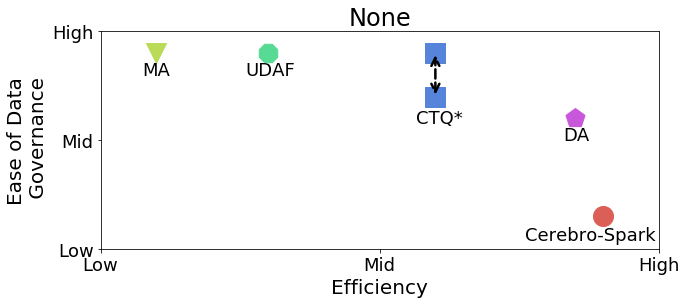

In [57]:
points = [
    [9, 1.5], 
    [1, 9], 
    [3, 9], 
    [6, 7], 
    [8.5, 6],
    [6, 9]
]
text_poses = [
    [7.6, 0.4], 
    [0.75, 8.0], 
    [2.6, 8.0], 
    [5.65, 5.8], 
    [8.3, 5],
    [0,0]
]

plot_trade_off = PlotterBase(xlabel='Efficiency', ylabel='Ease of Data\n Governance', set_ticks=False, figsize=(10, 4))
makers = ['o', 'v', '8', 's', 'p', 's']
delta = 0.1
for method, point, marker, text_pos in zip(methods_tradeoff, points, makers, text_poses):
    if method == 'CTQ':
        method = 'CTQ*'
    if method == 'CTQ_a':
        plot_trade_off.ax.scatter(point[0], point[1], s=400, label=method, marker=marker, c=palette[3])
    else:
        plot_trade_off.ax.scatter(point[0], point[1], s=400, label=method, marker=marker)
    if method != 'CTQ_a':
        plot_trade_off.ax.text(text_pos[0], text_pos[1], method, fontsize=18)
# plot_trade_off.ax.arrow(points[3][0], points[3][1], 0, 2, head_width=0.2, fc='k', ec='k', linestyle='--', arrowprops=dict(arrowstyle='<->')) 
plot_trade_off.ax.annotate(s='', xy=(points[3][0], 9), xytext=(points[3][0], points[3][1]), arrowprops=dict(arrowstyle='<->', lw=2.5, linestyle='dashed'))

plot_trade_off.ax.set_xticks([0, 5, 10])  
plot_trade_off.ax.set_xticklabels(['Low', 'Mid', 'High'], fontsize=18)
plot_trade_off.ax.set_yticks([0, 5, 10])  
plot_trade_off.ax.set_yticklabels(['Low', 'Mid', 'High'], fontsize=18)

In [58]:
save_fig(plot_trade_off.fig, '2d_trade_offs')

### End to End


In [86]:
methods

odict_keys(['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA-Cerebro', 'PyTDDP', 'DA-PyTDDP'])

#### ImageNet

In [14]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase

from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns
palette = sns.color_palette("hls", len(methods))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
methods

odict_keys(['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA-Cerebro', 'PyTDDP', 'DA-PyTDDP'])

In [22]:
log_dirs_all = {
    'ma': {
        'log_root': '../logs',
        'gpu_logs': 'gpu_logs',
        'cpu_logs': 'cpu_logs',
        'timestamp': '2020_04_23_01_31_43',
        'timestamp_db': '2020_04_23_01_32_31',
        'num_models': 16,
        'method': 'ma',
        'exp_name': 'gp_ma_baseline_modified_buffer_2020_04_23_01_32_31'
    },
    'udaf': {
        'log_root': '../logs',
        'gpu_logs': 'gpu_logs',
        'cpu_logs': 'cpu_logs',
        'timestamp': '2020_04_24_22_05_00',
        'timestamp_db': '2020_04_24_22_05_04',
        'num_models': 16,
        'method': 'udaf',
        'exp_name': 'gp_cerebro_modified_buffer_2020_04_24_22_05_04'
    },
    'ctq': {
        'log_root': '../logs',
        'gpu_logs': 'gpu_logs_july_august',
        'cpu_logs': 'cpu_logs_july_august',
        'timestamp': '2020_08_18_16_47_28',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq'
    },
    'da': {
        'log_root': '../logs',
        'gpu_logs': 'gpu_logs_july_august',
        'cpu_logs': 'cpu_logs_july_august',
        'timestamp': '2020_08_14_16_08_52',
        'method': 'da',
        'exp_name': 'e2e_da_cerebro_standalone'
    },
    'filesystem': {
        'log_root': '../logs',
        'gpu_logs': 'gpu_logs_july_august',
        'cpu_logs': 'cpu_logs_july_august',
        'timestamp': '2020_08_12_17_22_58',
        'method': 'filesystem',
        'exp_name': 'e2e_filesystem_cerebro_standalone'
    },
    'ddp':{
        'log_root': '../logs/all_logs_gpu_2021feb',
        'gpu_logs': 'gpu_logs',
        'cpu_logs': 'cpu_logs',
        'timestamp': '2021_02_05_16_57_58',
        'method': 'ddp',
        'exp_name': 'e2e_imagenet_pytorchddp'
    },
    'da-ddp':{
        'log_root': '../logs/all_logs_gpu_2021feb',
        'gpu_logs': 'gpu_logs',
        'cpu_logs': 'cpu_logs',
        'timestamp': '2021_02_10_17_53_47',
        'method': 'da-ddp',
        'exp_name': 'e2e_imagenet_pytorchddp_da'
    }
}
for method, method_dict in log_dirs_all.items():
    method_dict['network_logs'] = 'network_logs'
    method_dict['disk_logs'] = 'disk_logs'


Cerebro-Spark
Original time: 2020-08-12 17:22:58 to 2020-08-13 16:15:55
Shifted time: 2020-08-12 17:22:58 to 2020-08-13 16:15:55
cpu_utilization_worker5.log
cpu_utilization_worker3.log
cpu_utilization_worker6.log
cpu_utilization_worker1.log
cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker2.log
cpu_utilization_worker7.log
Average CPUmemory utilization: 19.12269861395385 %
Original time: 2020-08-12 17:22:58 to 2020-08-13 16:15:55
Shifted time: 2020-08-12 17:22:58 to 2020-08-13 16:15:55
gpu_utilization_worker4.log
gpu_utilization_worker6.log
gpu_utilization_worker3.log
gpu_utilization_worker1.log
gpu_utilization_worker2.log
gpu_utilization_worker5.log
gpu_utilization_worker7.log
gpu_utilization_worker0.log
Average GPUmemory utilization: 39.999279819080655 %
Original time: 2020-08-12 17:22:58 to 2020-08-13 16:15:55
Shifted time: 2020-08-12 17:22:58 to 2020-08-13 16:15:55
cpu_utilization_worker5.logcpu_utilization_worker3.log

cpu_utilization_worker6.log
cpu_ut

Text(0.5, 1.0, '(A) Learning Curve on Validation (ImageNet)')

/usr/local/lib/python3.7/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


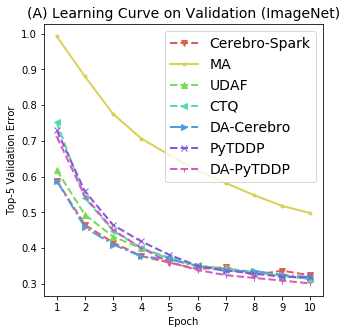

In [23]:
plot_e2e = PlotterBase(xlabel='Epoch', ylabel='Top-5 Validation Error', title='(A) Learning Curve on Validation (ImageNet)', set_ticks=True)
line_fmts = ['v--',  '.-', '^--', '<--', '>-.', 'x--', '1--']
la_dict = {}
for method, fmt in list(zip(methods, line_fmts)):
    print(method)
    method_name_e2e = e2e_methods_dict_reverse[method]
    log_dirs = log_dirs_all[method_name_e2e]
    df_grand_list = []
    find_first = False if method in ['PyTDDP'] else True
    la = LogAnalyzer(find_first=find_first, **log_dirs)
    la_dict[method] = la
    
    shift = 2.6 * 3600 if method_name_e2e == 'da' or method_name_e2e == 'da-ddp' else 0
    df_grand, x, y = la.get_learning_curve()
    plot_e2e.plot(x, y, fmt, label=method)
    avg_main_mem_utilization = la.report_cpu_memory_utilization(shift=shift)
    avg_gpu_mem_utilization = la.report_gpu_memory_utilization(shift=shift)
    avg_cpu_utilization = la.report_cpu_utilization(shift=shift)
plot_e2e.ax.legend(ncol=1, fontsize=14)

# plot_e2e.fig.tight_layout()

plot_e2e.ax.set_title('(A) Learning Curve on Validation (ImageNet)', fontsize=14)

Cerebro-Spark
MA
LOOKING FOR gp_ma_baseline_modified_buffer_2020_04_23_01_32_31_2020_04_23_01_32_31.pickle
UDAF
CTQ
DA-Cerebro
PyTDDP
DA-PyTDDP


Text(0.5, 1.0, '(A) Learning Curve on Validation (ImageNet)')

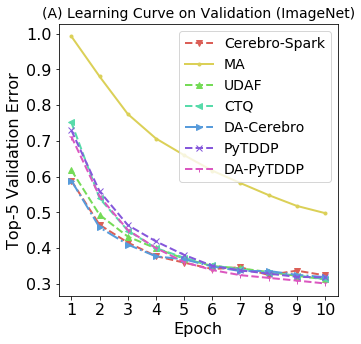

In [80]:
plot_e2e = PlotterBase(xlabel='Epoch', ylabel='Top-5 Validation Error', title='(A) Learning Curve on Validation (ImageNet)', set_ticks=True)
line_fmts = ['v--',  '.-', '^--', '<--', '>-.', 'x--', '1--']
la_dict = {}
for method, fmt in list(zip(methods, line_fmts)):
    print(method)
    method_name_e2e = e2e_methods_dict_reverse[method]
    log_dirs = log_dirs_all[method_name_e2e]
    df_grand_list = []
    find_first = False if method in ['PyTDDP'] else True
    la = LogAnalyzer(find_first=find_first, **log_dirs)
    la_dict[method] = la
    
    shift = 2.6 * 3600 if method_name_e2e == 'da' or method_name_e2e == 'da-ddp' else 0
    df_grand, x, y = la.get_learning_curve()
    plot_e2e.plot(x, y, fmt, label=method)
plot_e2e.ax.legend(ncol=1, fontsize=14)

# plot_e2e.fig.tight_layout()

plot_e2e.ax.set_title('(A) Learning Curve on Validation (ImageNet)', fontsize=14)

/usr/local/lib/python3.7/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


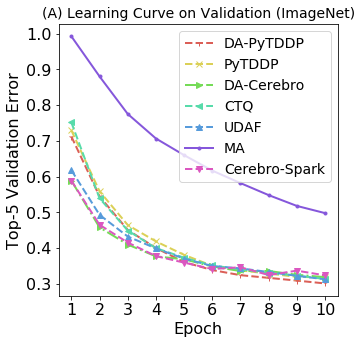

In [78]:
plot_e2e.fig

In [81]:
plot_e2e.save('e2e')

#### Criteo

In [2]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase

from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns
palette = sns.color_palette("hls", 5)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DA-Cerebro
Method: da
Total time: 23.580555555555556 hrs
Original time: 2020-10-14 03:31:04 to 2020-10-15 03:05:54
Shifted time: 2020-10-14 05:25:00 to 2020-10-15 03:05:54
cpu_utilization_worker7.log
cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker1.log
cpu_utilization_worker6.logcpu_utilization_worker3.log

cpu_utilization_worker2.log
cpu_utilization_worker5.log
Average CPUprocessor utilization: 37.04394165221001 %
Original time: 2020-10-14 03:31:04 to 2020-10-15 03:05:54
Shifted time: 2020-10-14 05:25:00 to 2020-10-15 03:05:54
cpu_utilization_worker7.log
cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker1.log
cpu_utilization_worker6.logcpu_utilization_worker3.log

cpu_utilization_worker2.log
cpu_utilization_worker5.log
Average CPUmemory utilization: 28.459762907507017 %
CTQ
Method: ctq
Total time: 41.11611111111111 hrs
Original time: 2020-10-19 18:33:55 to 2020-10-21 11:40:53
Shifted time: 2020-10-19 18:33:55 to 2020-10-21 11:

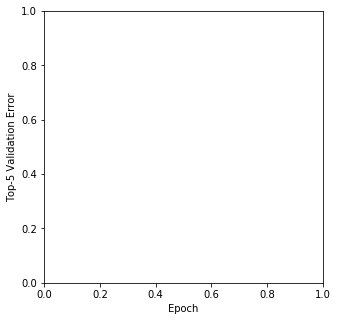

In [8]:
log_dirs_all = {
    'ma': {
        'log_root': '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_21_13_58_50',
        'timestamp_db': '2020_10_21_13_59_04',
        'num_models': 16,
        'method': 'ma',
        'exp_name': 'ma'
    },
    'udaf': {
        'log_root': '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_15_10_54_12',
        'timestamp_db': '2020_10_15_10_54_30',
        'num_models': 16,
        'method': 'udaf',
        'exp_name': 'cerebro'
    },
    'ctq': {
        'log_root': '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_19_18_33_55',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq'
    },
    'da': {
        'log_root': '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_14_03_31_04',
        'method': 'da',
        'exp_name': 'cerebro-da'
    },
    'filesystem': {
        'log_root': '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_18_04_02_57',
        'method': 'filesystem',
        'exp_name': 'e2e_filesystem_cerebro_standalone'
    }}
for method, method_dict in log_dirs_all.items():
    method_dict['network_logs'] = 'network_logs_september'

plot_e2e = PlotterBase(xlabel='Epoch', ylabel='Top-5 Validation Error', set_ticks=True)
line_fmts = ['v--', '.-', '^--', '<--', '>-.' ]
la_dict = {}
network_logs = {}
for method, fmt in list(zip(methods, line_fmts))[::-1]:
    print(method)
    method_name_e2e = e2e_methods_dict_reverse[method]
    log_dirs = log_dirs_all[method_name_e2e]
    df_grand_list = []
    la = LogAnalyzer(find_first=True, **log_dirs)
    la_dict[method] = la
    total_time = la.report_runtimes()
    if method_name_e2e == 'da':
#         shift off the ETL portion
        shift = 6836
    else:
        shift = 0
    avg_cpu_utilization = la.report_cpu_utilization(shift=shift)
    avg_main_mem_utilization = la.report_cpu_memory_utilization(shift=shift)
#     df_grand, x, y = la.get_learning_curve(top_5=False)
    
    

### Network & Disk costs

In [24]:
methods

odict_keys(['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA-Cerebro', 'PyTDDP', 'DA-PyTDDP'])

#### ImageNet

In [25]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase

from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns
palette = sns.color_palette("hls", len(methods))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
methods

odict_keys(['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA-Cerebro', 'PyTDDP', 'DA-PyTDDP'])

In [27]:
log_dirs_all = {
    'ddp':{
        'timestamp': '2021_02_05_16_57_58',
        'method': 'ddp',
        'exp_name': 'e2e_imagenet_pytorchddp'
    },
    'da-ddp':{
        'timestamp': '2021_02_10_17_53_47',
        'method': 'da-ddp',
        'exp_name': 'e2e_imagenet_pytorchddp_da'
    },
    'udaf':{
        'timestamp': '2021_02_14_12_48_10',
        'method': 'udaf',
        'exp_name': 'cerebro',
        'timestamp_db': '2021_02_14_12_49_19',
        'num_models': 16,
    },
    'ctq': {
        'timestamp': '2021_02_20_15_51_06',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq'
    },
    'ma': {
        'timestamp': '2021_02_18_21_37_39',
        'timestamp_db': '2021_02_18_21_38_43',
        'num_models': 16,
        'method': 'ma',
        'exp_name': 'ma'
    },
    'da': {
        'timestamp': '2021_02_17_21_09_23',
        'method': 'da',
        'exp_name': 'cerebro-da'
    },
    'filesystem': {
        'timestamp': '2021_02_16_21_59_11',
        'method': 'filesystem',
        'exp_name': 'e2e_filesystem_cerebro_standalone'
    },
    'cerebro-spark': {
        'timestamp': '2021_03_30_04_10_25',
        'method': 'cerebro-spark',
        'exp_name': 'e2e_filesystem_cerebro_spark'
    }
    
}
for method, method_dict in log_dirs_all.items():
    method_dict['network_logs'] = 'network_logs'
    method_dict['cpu_logs'] = 'cpu_logs'
    method_dict['gpu_logs'] = 'gpu_logs'
    method_dict['disk_logs'] = 'disk_logs'
    method_dict['method'] = method
    method_dict['log_root'] = '../logs/all_logs_gpu_2021feb'

In [549]:
line_fmts = ['v--',  '.-', '^--', '<--', '>-.', 'x--', '1--']
disk_logs = {}
network_logs = {}
la_dict = {}

for method, fmt in list(zip(methods, line_fmts)):
    print(method)
    method_name_e2e = e2e_methods_dict_reverse[method]
    log_dirs = log_dirs_all[method_name_e2e]
    df_grand_list = []
    find_first = False if method in ['PyTDDP'] else True
    la = LogAnalyzer(find_first=find_first, **log_dirs)
    total_time = la.report_runtimes()
    la_dict[method] = la
#     shift off the ETL part
    if method == 'DA-Cerebro':
        shift = 9500
    elif method == 'DA-PyTDDP':
        shift = 8750
    elif method == 'Cerebro-Spark':
        shift = 9500
    elif method == 'PyTDDP':
        shift = 60
    df_grand, df_read, df_wrtns = la.report_disk(shift=shift, separateio=True)
    disk_logs[method] = (df_grand, df_read, df_wrtns)
    
    network_master, network_workers = la.report_network(shift)
    network_logs[method] = (network_master, network_workers)
    
    
    avg_main_mem_utilization = la.report_cpu_memory_utilization(shift=shift)
    avg_gpu_mem_utilization = la.report_gpu_memory_utilization(shift=shift)
    avg_cpu_utilization = la.report_cpu_utilization(shift=shift)
    
    

Cerebro-Spark
Method: filesystem
Total time: 21.551944444444445 hrs
Original time: 2021-02-16 21:59:12 to 2021-02-17 19:32:19
Shifted time: 2021-02-16 22:01:52 to 2021-02-17 19:32:19
disk_worker6.log
disk_master.log
disk_worker2.log
disk_worker1.log
disk_worker0.log
disk_worker5.log
disk_worker4.log
disk_worker7.log
disk_worker3.log
Per worker reads (GB): sum    0.768555
dtype: float64, Total reads (GB): sum    6.148438
dtype: float64
Per worker writes (GB): sum    0.343262
dtype: float64, Total writes (GB): sum    2.746094
dtype: float64
Original time: 2021-02-16 21:59:12 to 2021-02-17 19:32:19
Shifted time: 2021-02-16 22:01:52 to 2021-02-17 19:32:19
network_worker2.log
network_worker3.log
network_worker7.log
network_worker0.log
network_master.log
network_worker4.log
network_worker6.log
network_worker5.log
network_worker1.log
master stats:rxtxkB/s  mean    8.005966e+03
          max     1.053977e+06
Name: EXP, dtype: float64
workers stats:rxtxkB/s  mean       979.622001
          max 

cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker2.log
cpu_utilization_worker7.log
Average CPUprocessor utilization: 2.2445086710005615 %
CTQ
Method: ctq
Total time: 44.2725 hrs
Original time: 2021-02-20 15:51:08 to 2021-02-22 12:07:29
Shifted time: 2021-02-20 15:53:48 to 2021-02-22 12:07:29
disk_worker6.log
disk_master.log
disk_worker2.log
disk_worker1.log
disk_worker0.log
disk_worker5.log
disk_worker4.log
disk_worker7.log
disk_worker3.log
Per worker reads (GB): sum    11.776733
dtype: float64, Total reads (GB): sum    94.213867
dtype: float64
Per worker writes (GB): sum    152.325562
dtype: float64, Total writes (GB): sum    1218.604492
dtype: float64
Original time: 2021-02-20 15:51:08 to 2021-02-22 12:07:29
Shifted time: 2021-02-20 15:53:48 to 2021-02-22 12:07:29
network_worker2.log
network_worker3.log
network_worker7.log
network_worker0.log
network_master.log
network_worker4.log
network_worker6.log
network_worker5.log
network_worker1.log
master stats:rx

disk_master.log
disk_worker2.log
disk_worker1.log
disk_worker0.log
disk_worker5.log
disk_worker4.log
disk_worker7.log
disk_worker3.log
Per worker reads (GB): sum    0.0
dtype: float64, Total reads (GB): sum    0.0
dtype: float64
Per worker writes (GB): sum    1.337402
dtype: float64, Total writes (GB): sum    10.699219
dtype: float64
Original time: 2021-02-10 17:53:47 to 2021-02-14 02:00:30
Shifted time: 2021-02-10 20:19:37 to 2021-02-14 02:00:30
network_worker2.log
network_worker3.log
network_worker7.log
network_worker0.log
network_master.log
network_worker4.log
network_worker6.log
network_worker5.log
network_worker1.log
master stats:rxtxkB/s  mean    161.141299
          max     341.480000
Name: EXP, dtype: float64
workers stats:rxtxkB/s  mean    1.892688e+06
          max     2.237969e+06
Name: EXP, dtype: float64
Total GB transmitted over network: 2019063.0947857392
Original time: 2021-02-10 17:53:47 to 2021-02-14 02:00:30
Shifted time: 2021-02-10 20:19:37 to 2021-02-14 02:00:30
cp

In [35]:
method = 'cerebro-spark'
log_dirs = log_dirs_all[method]

la = LogAnalyzer(find_first=True, **log_dirs)

lines = readlines(os.path.join(la.exp_root, 'client.log'))

actual_start_str = '2021-03-30 04:43:51'

actual_start = datetime.datetime.strptime(actual_start_str, TIME_FORMAT)
shift = (actual_start - la.start_end_dict[method][2]).total_seconds() + 1

In [39]:
la.report_runtimes() - shift/3600

Method: cerebro-spark
Total time: 24.455833333333334 hrs


23.90138888888889

In [38]:
df_grand, df_read, df_wrtns = la.report_disk(shift=shift, separateio=True)

Original time: 2021-03-30 04:10:36 to 2021-03-31 04:37:57
Shifted time: 2021-03-30 04:43:52 to 2021-03-31 04:37:57
Per worker reads (GB): sum    0.238403
dtype: float64, Total reads (GB): sum    1.907227
dtype: float64
Per worker writes (GB): sum    1.602783
dtype: float64, Total writes (GB): sum    12.822266
dtype: float64


In [41]:
network_master, network_workers = la.report_network(shift=shift)

Original time: 2021-03-30 04:10:36 to 2021-03-31 04:37:57
Shifted time: 2021-03-30 04:43:52 to 2021-03-31 04:37:57
master stats:rxtxkB/s  mean    1.343083e+04
          max     1.206975e+06
Name: EXP, dtype: float64
workers stats:rxtxkB/s  mean      1674.204544
          max     236155.300000
Name: EXP, dtype: float64
Total GB transmitted over network: 1089.0066502457705


In [42]:
avg_gpu_utilization = la.report_gpu_utilization(shift=shift)
avg_main_mem_utilization = la.report_cpu_memory_utilization(shift=shift)
avg_cpu_utilization = la.report_cpu_utilization(shift=shift)
avg_gpu_mem_utilization = la.report_gpu_memory_utilization(shift=shift)


Original time: 2021-03-30 04:10:36 to 2021-03-31 04:37:57
Shifted time: 2021-03-30 04:43:52 to 2021-03-31 04:37:57
gpu_utilization_worker4.log
gpu_utilization_worker6.log
gpu_utilization_worker3.log
gpu_utilization_worker1.log
gpu_utilization_worker2.log
gpu_utilization_worker5.loggpu_utilization_worker7.log

gpu_utilization_worker0.log
Average GPUprocessor utilization: 65.12544245051984 %
Original time: 2021-03-30 04:10:36 to 2021-03-31 04:37:57
Shifted time: 2021-03-30 04:43:52 to 2021-03-31 04:37:57
cpu_utilization_worker5.log
cpu_utilization_worker3.log
cpu_utilization_worker6.log
cpu_utilization_worker1.log
cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker2.log
cpu_utilization_worker7.log
Average CPUmemory utilization: 17.414338424461263 %
Original time: 2021-03-30 04:10:36 to 2021-03-31 04:37:57
Shifted time: 2021-03-30 04:43:52 to 2021-03-31 04:37:57
cpu_utilization_worker5.log
cpu_utilization_worker3.log
cpu_utilization_worker6.log
cpu_utilization_w

#### Criteo

In [20]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase

from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns
palette = sns.color_palette("hls", len(methods))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
log_dirs_all = {
    'ma': {
        'timestamp': '2021_03_01_15_01_11',
        'timestamp_db': '2021_03_01_15_01_29',
        'num_models': 16,
        'method': 'ma',
        'exp_name': 'ma'
    },
    'udaf': {
        'timestamp': '2021_03_08_12_59_15',
        'timestamp_db': '2021_03_08_12_59_40',
        'num_models': 16,
        'method': 'udaf',
        'exp_name': 'cerebro'
    }, 
    'ctq': {
        'timestamp': '2021_03_06_12_48_16',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq'
    }, 
    'da': {
        'timestamp': '2021_02_25_20_45_09',
        'method': 'da',
        'exp_name': 'cerebro-da'
    }, 
    'filesystem': {
        'timestamp': '2021_02_03_14_20_12',
        'method': 'filesystem',
        'exp_name': 'e2e_filesystem_cerebro_standalone'
    },
    'cerebro-spark': {
        'timestamp': '2021_03_31_16_15_20',
        'method': 'cerebro-spark',
        'exp_name': 'e2e_filesystem_cerebro_spark'
    }
}

for method, method_dict in log_dirs_all.items():
    method_dict['network_logs'] = 'network_logs'
    method_dict['disk_logs'] = 'disk_logs'
    method_dict['cpu_logs'] = 'cpu_logs'
    method_dict['gpu_logs'] = 'gpu_logs'
    method_dict['log_root'] = '../logs/all_logs_cpu_2021feb'
    

In [22]:
method = 'cerebro-spark'
log_dirs = log_dirs_all[method]

la = LogAnalyzer(find_first=True, **log_dirs)

lines = readlines(os.path.join(la.exp_root, 'client.log'))

actual_start_str = [x for x in lines if 'Starting EPOCH Training' in x][0].split(": ")[1].split(", ")[0]

actual_start = datetime.datetime.strptime('2021-03-31 16:38:25', TIME_FORMAT)
shift = (actual_start - la.start_end_dict[method][2]).total_seconds() + 1

In [8]:
df_grand, df_read, df_wrtns = la.report_disk(shift=shift, separateio=True)

Original time: 2021-03-31 16:15:29 to 2021-04-01 18:45:56
Shifted time: 2021-03-31 16:17:18 to 2021-04-01 18:45:56
disk_master.log
disk_worker4.log
disk_worker1.log
disk_worker6.log
disk_worker7.log
disk_worker5.log
disk_worker3.log
disk_worker2.log
disk_worker0.log
Per worker reads (GB): sum    0.220215
dtype: float64, Total reads (GB): sum    1.761719
dtype: float64
Per worker writes (GB): sum    1.2229
dtype: float64, Total writes (GB): sum    9.783203
dtype: float64


In [9]:
network_master, network_workers = la.report_network(0)

Original time: 2021-03-31 16:15:29 to 2021-04-01 18:45:56
Shifted time: 2021-03-31 16:15:29 to 2021-04-01 18:45:56
network_worker6.log
network_worker2.log
network_worker0.log
network_worker1.log
network_worker7.log
network_worker5.log
network_master.log
network_worker3.log
network_worker4.log
master stats:rxtxkB/s  mean      4302.469526
          max     255963.220000
Name: EXP, dtype: float64
workers stats:rxtxkB/s  mean       535.679839
          max     119110.580000
Name: EXP, dtype: float64
Total GB transmitted over network: 392.37416830182605


In [13]:
avg_cpu_utilization = la.report_cpu_utilization(shift=shift)
avg_main_mem_utilization = la.report_cpu_memory_utilization(shift=shift)

Original time: 2021-03-31 16:15:29 to 2021-04-01 18:45:56
Shifted time: 2021-03-31 16:17:18 to 2021-04-01 18:45:56
cpu_utilization_worker7.log
cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker1.log
cpu_utilization_worker6.log
cpu_utilization_worker3.log
cpu_utilization_worker2.log
cpu_utilization_worker5.log
Average CPUprocessor utilization: 44.49680816446297 %
Original time: 2021-03-31 16:15:29 to 2021-04-01 18:45:56
Shifted time: 2021-03-31 16:17:18 to 2021-04-01 18:45:56
cpu_utilization_worker7.log
cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker1.log
cpu_utilization_worker6.logcpu_utilization_worker3.log

cpu_utilization_worker2.log
cpu_utilization_worker5.log
Average CPUmemory utilization: 11.393769694326597 %


In [37]:
line_fmts = ['v--', '.-', '^--', '<--', '>-.' ]
la_dict = {}
network_logs = {}
disk_logs = {}
methods = ['CTQ', 'MA',  'UDAF', 'DA-Cerebro']
for method, fmt in list(zip(methods, line_fmts)):
    print(method)
    method_name_e2e = e2e_methods_dict_reverse[method]
    log_dirs = log_dirs_all[method_name_e2e]
    df_grand_list = []
    la = LogAnalyzer(find_first=True, **log_dirs)
    la_dict[method] = la
    if method in ['DA-Cerebro', 'DA-PyTDDP']:
#         shift off the ETL portion
        shift = 6690
    elif method in ['Cerebro-Spark']:
        shift = 106
    else:
        shift = 0
    df_grand, reads, wrtns = la.report_disk(shift, separateio=True)
    disk_logs[method] = df_grand, reads, wrtns
    network_master, network_workers = la.report_network(shift)
    network_logs[method] = (network_master, network_workers)
    

CTQ
Method: ctq
Total time: 43.40694444444444 hrs
Original time: 2021-03-06 12:48:17 to 2021-03-08 08:12:42
Shifted time: 2021-03-06 12:48:17 to 2021-03-08 08:12:42
Per worker reads (GB): sum    1.22583
dtype: float64, Total reads (GB): sum    9.806641
dtype: float64
Per worker writes (GB): sum    21.596802
dtype: float64, Total writes (GB): sum    172.774414
dtype: float64
Original time: 2021-03-06 12:48:17 to 2021-03-08 08:12:42
Shifted time: 2021-03-06 12:48:17 to 2021-03-08 08:12:42
master stats:rxtxkB/s  mean       535.375356
          max     255702.880000
Name: EXP, dtype: float64
workers stats:rxtxkB/s  mean       61.285103
          max     32169.720000
Name: EXP, dtype: float64
Total GB transmitted over network: 77.35778716505173
MA
Method: ma
Total time: 38.72805555555556 hrs
Original time: 2021-03-01 15:01:13 to 2021-03-03 05:44:54
Shifted time: 2021-03-01 15:01:13 to 2021-03-03 05:44:54
Per worker reads (GB): sum    0.880127
dtype: float64, Total reads (GB): sum    7.04101

In [24]:
line_fmts = ['v--', '.-', '^--', '<--', '>-.' ]
la_dict = {}
network_logs = {}
disk_logs = {}
methods = ['Cerebro-Spark']
for method, fmt in list(zip(methods, line_fmts)):
    print(method)
    method_name_e2e = e2e_methods_dict_reverse[method]
    log_dirs = log_dirs_all[method_name_e2e]
    df_grand_list = []
    la = LogAnalyzer(find_first=True, **log_dirs)
    la_dict[method] = la
    if method in ['DA-Cerebro', 'DA-PyTDDP']:
#         shift off the ETL portion
        shift = 6690
    elif method in ['Cerebro-Spark']:
        shift = 106
    else:
        shift = 0
    df_grand, reads, wrtns = la.report_disk(shift, separateio=True)
    disk_logs[method] = df_grand, reads, wrtns
    network_master, network_workers = la.report_network(shift)
    network_logs[method] = (network_master, network_workers)
    avg_cpu_utilization = la.report_cpu_utilization(shift=shift)
    avg_main_mem_utilization = la.report_cpu_memory_utilization(shift=shift)

Cerebro-Spark
Original time: 2021-02-03 14:20:12 to 2021-02-04 12:21:09
Shifted time: 2021-02-03 14:21:58 to 2021-02-04 12:21:09
Per worker reads (GB): sum    0.0
dtype: float64, Total reads (GB): sum    0.0
dtype: float64
Per worker writes (GB): sum    0.348633
dtype: float64, Total writes (GB): sum    2.789062
dtype: float64
Original time: 2021-02-03 14:20:12 to 2021-02-04 12:21:09
Shifted time: 2021-02-03 14:21:58 to 2021-02-04 12:21:09
master stats:rxtxkB/s  mean      2348.432955
          max     379926.350000
Name: EXP, dtype: float64
workers stats:rxtxkB/s  mean      285.072044
          max     97004.630000
Name: EXP, dtype: float64
Total GB transmitted over network: 176.80067476812923
Original time: 2021-02-03 14:20:12 to 2021-02-04 12:21:09
Shifted time: 2021-02-03 14:21:58 to 2021-02-04 12:21:09
cpu_utilization_worker7.log
cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker1.log
cpu_utilization_worker6.log
cpu_utilization_worker3.log
cpu_utilizatio

### Hyperopt

In [141]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase
from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns

hyperopt_methods = OrderedDict({
    'cerebro_spark-hyperopt' : 'Hyperopt-Cerebro-Spark',
    'cerebro_standalone-hyperopt' : 'Hyperopt-Cerebro-Standalone',
    'udaf-hyperopt' : 'Hyperopt-UDAF',
    'ctq-hyperopt' : 'Hyperopt-CTQ',
    'da-hyperopt' : 'Hyperopt-DA',
    'spark-hyperopt': 'Hyperopt-Spark',
    
})
DA_SHIFT = 9479
CEREBRO_SHIFT = 150
palette = sns.color_palette("hls", len(hyperopt_methods))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
log_dirs_all = {
    'udaf-hyperopt':{
        'timestamp': '2021_02_24_16_38_05',
        'exp_name': 'udaf-hyperopt',
        'timestamp_db': '2021_02_24_16_38_27',
    },
    'ctq-hyperopt':{
        'timestamp': '2021_02_27_20_21_34',
        'method': 'ctq-hyperopt',
        'exp_name': 'ctq-hyperopt',
    },
    'da-hyperopt':{
        'timestamp': '2021_03_06_02_16_29',
        'exp_name': 'da-hyperopt',
    },
    'cerebro_standalone-hyperopt':{
        'timestamp': '2021_03_07_16_07_29',
        'exp_name': 'cerebro_standalone-hyperopt',
    },
    'cerebro_spark-hyperopt':{
        'timestamp': '2021_04_02_20_27_41',
        'exp_name': 'cerebro_spark-hyperopt',
    },
    'spark-hyperopt':{
        'timestamp': '2021_03_11_17_46_51',
        'exp_name': 'spark-hyperopt',
    }
    
}
for method, method_dict in log_dirs_all.items():
    method_dict['network_logs'] = 'network_logs'
    method_dict['cpu_logs'] = 'cpu_logs'
    method_dict['gpu_logs'] = 'gpu_logs'
    method_dict['disk_logs'] = 'disk_logs'
    method_dict['method'] = method
    method_dict['log_root'] = '../logs/all_logs_gpu_2021feb'
    method_dict['num_models'] = 32


In [143]:
hyperopt_methods

OrderedDict([('cerebro_spark-hyperopt', 'Hyperopt-Cerebro-Spark'),
             ('cerebro_standalone-hyperopt', 'Hyperopt-Cerebro-Standalone'),
             ('udaf-hyperopt', 'Hyperopt-UDAF'),
             ('ctq-hyperopt', 'Hyperopt-CTQ'),
             ('da-hyperopt', 'Hyperopt-DA'),
             ('spark-hyperopt', 'Hyperopt-Spark')])

In [56]:
method = 'cerebro_spark-hyperopt'
log_dirs = log_dirs_all[method]

la = LogAnalyzer(find_first=True, **log_dirs)

lines = readlines(os.path.join(la.exp_root, 'client.log'))

actual_start_str = '2021-04-02 21:02:05'

actual_start = datetime.datetime.strptime(actual_start_str, TIME_FORMAT)
shift = (actual_start - la.start_end_dict[method][2]).total_seconds() + 1

In [49]:
df_grand, df_read, df_wrtns = la.report_disk(shift=shift, separateio=True)

Original time: 2021-04-02 20:27:42 to 2021-04-04 03:17:29
Shifted time: 2021-04-02 21:02:06 to 2021-04-04 03:17:29
Per worker reads (GB): sum    0.29187
dtype: float64, Total reads (GB): sum    2.334961
dtype: float64
Per worker writes (GB): sum    2.065063
dtype: float64, Total writes (GB): sum    16.520508
dtype: float64


In [50]:
network_master, network_workers = la.report_network(shift=shift)

Original time: 2021-04-02 20:27:42 to 2021-04-04 03:17:29
Shifted time: 2021-04-02 21:02:06 to 2021-04-04 03:17:29
master stats:rxtxkB/s  mean     10955.903846
          max     676440.850000
Name: EXP, dtype: float64
workers stats:rxtxkB/s  mean      1397.774616
          max     199582.000000
Name: EXP, dtype: float64
Total GB transmitted over network: 1160.5375145416979


In [51]:
avg_gpu_utilization = la.report_gpu_utilization(shift=shift)
avg_main_mem_utilization = la.report_cpu_memory_utilization(shift=shift)
avg_cpu_utilization = la.report_cpu_utilization(shift=shift)
avg_gpu_mem_utilization = la.report_gpu_memory_utilization(shift=shift)

Original time: 2021-04-02 20:27:42 to 2021-04-04 03:17:29
Shifted time: 2021-04-02 21:02:06 to 2021-04-04 03:17:29
gpu_utilization_worker4.log
gpu_utilization_worker6.log
gpu_utilization_worker3.log
gpu_utilization_worker1.log
gpu_utilization_worker2.log
gpu_utilization_worker5.log
gpu_utilization_worker7.log
gpu_utilization_worker0.log
Average GPUprocessor utilization: 43.56520467197306 %
Original time: 2021-04-02 20:27:42 to 2021-04-04 03:17:29
Shifted time: 2021-04-02 21:02:06 to 2021-04-04 03:17:29
cpu_utilization_worker5.logcpu_utilization_worker3.log

cpu_utilization_worker6.log
cpu_utilization_worker1.log
cpu_utilization_worker4.log
cpu_utilization_worker0.log
cpu_utilization_worker2.log
cpu_utilization_worker7.log
Average CPUmemory utilization: 19.101100905606778 %
Original time: 2021-04-02 20:27:42 to 2021-04-04 03:17:29
Shifted time: 2021-04-02 21:02:06 to 2021-04-04 03:17:29
cpu_utilization_worker5.log
cpu_utilization_worker3.log
cpu_utilization_worker6.log
cpu_utilization_w

Method: cerebro_spark-hyperopt
Total time: 30.829722222222223 hrs
Original time: 2021-04-02 20:27:42 to 2021-04-04 03:17:29
Shifted time: 2021-04-02 21:02:06 to 2021-04-04 03:17:29
BEST MODEL ACHIEVED: 0.3064928874373436
Method: cerebro_standalone-hyperopt
Total time: 34.83555555555556 hrs
Original time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
Shifted time: 2021-03-07 16:10:01 to 2021-03-09 02:57:39
BEST MODEL ACHIEVED: 0.33135974999999995
Method: udaf
Total time: 64.39583333333333 hrs
Original time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
Shifted time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
Found local pickles for udaf-hyperopt_info_2021_02_24_16_38_27.pickle, reading
Found local pickles for udaf-hyperopt_mst_table_2021_02_24_16_38_27.pickle, reading
Found local pickles for udaf-hyperopt_summary_2021_02_24_16_38_27.pickle, reading
BEST MODEL ACHIEVED: 0.333459973335266
Method: ctq
Total time: 91.4088888888889 hrs
Original time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
Shif

/local/cerebro-greenplum/exps/data_analytics.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid = df_aggregated[df_aggregated['mode'] == 'VALID']


BEST MODEL ACHIEVED: 0.33381700000000003
Method: spark-hyperopt
Total time: 33.91888888888889 hrs
Original time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
Shifted time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
BEST MODEL ACHIEVED: 0.31201979999999996


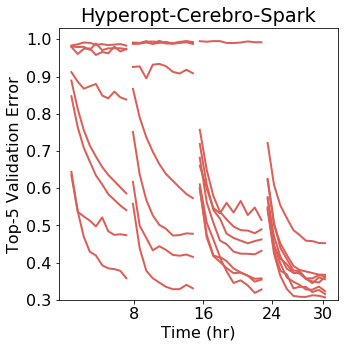

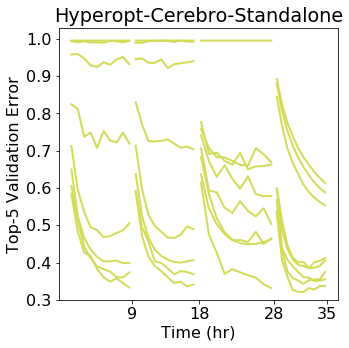

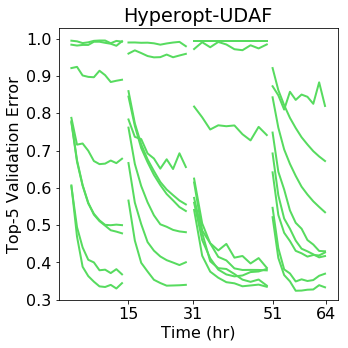

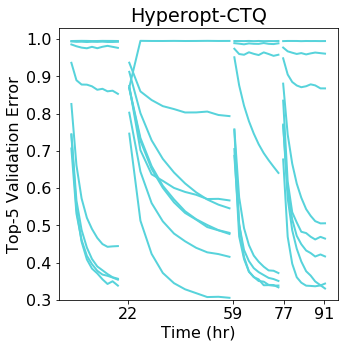

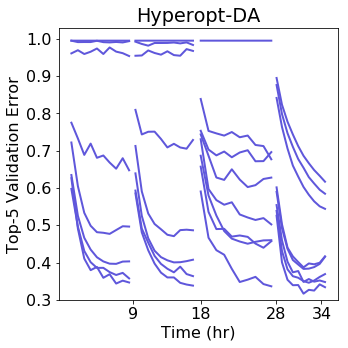

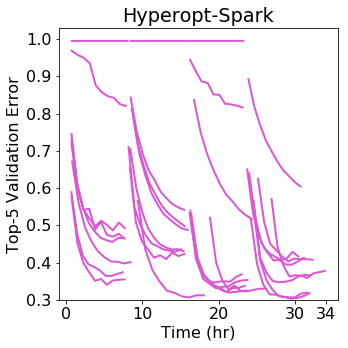

In [146]:
la_dict = {}
plotter_dict = {}
disk_summary = {}
for j, (method, figname) in enumerate(hyperopt_methods.items()):
    log_dirs = log_dirs_all[method]
    la = LogAnalyzer(find_first=False, **log_dirs)
    total_time = la.report_runtimes()
    la_dict[method] = la
    if method == 'da-hyperopt':
        shift = DA_SHIFT
    elif method == 'cerebro_standalone-hyperopt':
        shift = CEREBRO_SHIFT
    elif method == 'cerebro_spark-hyperopt':
        actual_start_str = '2021-04-02 21:02:05'
        actual_start = datetime.datetime.strptime(actual_start_str, TIME_FORMAT)
        shift = (actual_start - la.start_end_dict[method][2]).total_seconds() + 1
        
    else:
        shift = 0
    xaxis, df_subs = la.report_hyperopt(shift=shift, concurrency=8, epochs=10)
    
    plotter = PlotterBase(xlabel='Time (hr)', ylabel='Top-5 Validation Error', title=figname, set_ticks=False)
    
    best_model_val = 1.0
    for xa, df_sub in zip(xaxis, df_subs):
        for i, row in df_sub.iterrows():
            y = 1 - np.array(row['validation_metrics'])
            plotter.plot(xa, y, '-', color=palette[j], label=method)
            best_model_val = min(best_model_val, y[-1])
#         if method != 'spark-hyperopt':
#             plotter.ax.axvline(x=xa[0], color='k', linestyle='--')
            
    print("BEST MODEL ACHIEVED: {}".format(best_model_val))
    if method != 'spark-hyperopt':
        xticks = [x[0] for x in xaxis[1:]] + [xaxis[-1][-1]]
        xticks = [int(round(x)) for x in xticks]
    else:
        xticks = [0, 10, 20, 30, round(total_time)]
    plotter.ax.set_xticks(xticks)
    yticks = np.arange(0.3, 1.1, 0.1)
    plotter.ax.set_yticks(yticks)
    plotter.ax.set_ylim(bottom=0.3)
    plotter_dict[method] = plotter
#     la.report_gpu_utilization(shift=shift)
#     la.report_gpu_memory_utilization(shift=shift)
#     la.report_cpu_utilization(shift=shift)
#     la.report_cpu_memory_utilization(shift=shift)
#     df_grand, reads_summary, wrtns_summary = la.report_disk(shift=shift, separateio=True)
#     disk_summary[method] = (df_grand, reads_summary, wrtns_summary)
#     la.report_network(shift=shift)
    plotter.save(method)

In [1]:
# printed logs by the above
# Method: udaf-hyperopt
# Total time: 64.39583333333333 hrs
# Original time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# Shifted time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# Found local pickles for udaf-hyperopt_info_2021_02_24_16_38_27.pickle, reading
# Found local pickles for udaf-hyperopt_mst_table_2021_02_24_16_38_27.pickle, reading
# Found local pickles for udaf-hyperopt_summary_2021_02_24_16_38_27.pickle, reading
# Original time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# Shifted time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUprocessor utilization: 32.46801173559844 %
# Original time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# Shifted time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUmemory utilization: 16.244215876502352 %
# Original time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# Shifted time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUprocessor utilization: 2.378400239654403 %
# Original time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# Shifted time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUmemory utilization: 7.247855667839261 %
# Original time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# Shifted time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# disk_worker6.log
# disk_master.log
# disk_worker2.log
# disk_worker1.log
# disk_worker0.log
# disk_worker5.log
# disk_worker4.log
# disk_worker7.log
# disk_worker3.log
# Per worker reads (GB): sum    11.940918
# dtype: float64, Total reads (GB): sum    95.527344
# dtype: float64
# Per worker writes (GB): sum    173.227661
# dtype: float64, Total writes (GB): sum    1385.821289
# dtype: float64
# Original time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# Shifted time: 2021-02-24 16:38:11 to 2021-02-27 09:01:56
# network_worker2.log
# network_worker3.log
# network_worker7.log
# network_worker0.log
# network_master.log
# network_worker4.log
# network_worker6.log
# network_worker5.log
# network_worker1.log
# master stats:rxtxkB/s  mean       286.371236
#           max     805107.950000
# Name: EXP, dtype: float64
# workers stats:rxtxkB/s  mean       614.611036
#           max     432501.200000
# Name: EXP, dtype: float64
# Total GB transmitted over network: 579.7973936255632
# Method: ctq-hyperopt
# Total time: 91.4088888888889 hrs
# Original time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# Shifted time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# Original time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# Shifted time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUprocessor utilization: 33.218046041636114 %
# Original time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# Shifted time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUmemory utilization: 16.547554301423077 %
# Original time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# Shifted time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUprocessor utilization: 2.493267200809022 %
# Original time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# Shifted time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUmemory utilization: 1.4621885829074697 %
# Original time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# Shifted time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# disk_worker6.log
# disk_master.log
# disk_worker2.log
# disk_worker1.log
# disk_worker0.log
# disk_worker5.log
# disk_worker4.log
# disk_worker7.log
# disk_worker3.log
# Per worker reads (GB): sum    12.12207
# dtype: float64, Total reads (GB): sum    96.976562
# dtype: float64
# Per worker writes (GB): sum    92.093628
# dtype: float64, Total writes (GB): sum    736.749023
# dtype: float64
# Original time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# Shifted time: 2021-02-27 20:21:35 to 2021-03-03 15:46:07
# network_worker2.log
# network_worker3.log
# network_worker7.log
# network_worker0.log
# network_master.log
# network_worker4.log
# network_worker6.log
# network_worker5.log
# network_worker1.log
# master stats:rxtxkB/s  mean      1777.527924
#           max     356978.030000
# Name: EXP, dtype: float64
# workers stats:rxtxkB/s  mean      214.700319
#           max     89852.140000
# Name: EXP, dtype: float64
# Total GB transmitted over network: 549.1906284274971
# Method: da-hyperopt
# Total time: 37.103611111111114 hrs
# Original time: 2021-03-06 02:16:30 to 2021-03-07 15:22:43
# Shifted time: 2021-03-06 04:54:29 to 2021-03-07 15:22:43
# /local/cerebro-greenplum/exps/data_analytics.py:815: SettingWithCopyWarning: 
# A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead

# See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
#   df_valid['ERROR'] = 1 - df_valid['ERROR']
# Original time: 2021-03-06 02:16:30 to 2021-03-07 15:22:43
# Shifted time: 2021-03-06 04:54:29 to 2021-03-07 15:22:43
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUprocessor utilization: 45.25045360425366 %
# Original time: 2021-03-06 02:16:30 to 2021-03-07 15:22:43
# Shifted time: 2021-03-06 04:54:29 to 2021-03-07 15:22:43
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUmemory utilization: 24.069362690017925 %
# Original time: 2021-03-06 02:16:30 to 2021-03-07 15:22:43
# Shifted time: 2021-03-06 04:54:29 to 2021-03-07 15:22:43
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUprocessor utilization: 2.0477679023567683 %
# Original time: 2021-03-06 02:16:30 to 2021-03-07 15:22:43
# Shifted time: 2021-03-06 04:54:29 to 2021-03-07 15:22:43
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUmemory utilization: 20.220880953898792 %
# Original time: 2021-03-06 02:16:30 to 2021-03-07 15:22:43
# Shifted time: 2021-03-06 04:54:29 to 2021-03-07 15:22:43
# disk_worker6.log
# disk_master.log
# disk_worker2.log
# disk_worker1.log
# disk_worker0.log
# disk_worker5.log
# disk_worker4.log
# disk_worker7.log
# disk_worker3.log
# Per worker reads (GB): sum    0.696167
# dtype: float64, Total reads (GB): sum    5.569336
# dtype: float64
# Per worker writes (GB): sum    6.678101
# dtype: float64, Total writes (GB): sum    53.424805
# dtype: float64
# Original time: 2021-03-06 02:16:30 to 2021-03-07 15:22:43
# Shifted time: 2021-03-06 04:54:29 to 2021-03-07 15:22:43
# network_worker2.log
# network_worker3.log
# network_worker7.log
# network_worker0.log
# network_master.log
# network_worker4.log
# network_worker6.log
# network_worker5.log
# network_worker1.log
# master stats:rxtxkB/s  mean      4265.24699
#           max     529701.76000
# Name: EXP, dtype: float64
# workers stats:rxtxkB/s  mean      516.317988
#           max     90515.640000
# Name: EXP, dtype: float64
# Total GB transmitted over network: 496.5524487007769
# Method: cerebro_standalone-hyperopt
# Total time: 34.83555555555556 hrs
# Original time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# Shifted time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# Original time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# Shifted time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUprocessor utilization: 44.79114906741087 %
# Original time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# Shifted time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUmemory utilization: 23.804808725414784 %
# Original time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# Shifted time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUprocessor utilization: 2.0701177583505856 %
# Original time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# Shifted time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUmemory utilization: 15.783633980297193 %
# Original time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# Shifted time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# disk_worker6.log
# disk_master.log
# disk_worker2.log
# disk_worker1.log
# disk_worker0.log
# disk_worker5.log
# disk_worker4.log
# disk_worker7.log
# disk_worker3.log
# Per worker reads (GB): sum    24.156738
# dtype: float64, Total reads (GB): sum    193.253906
# dtype: float64
# Per worker writes (GB): sum    0.578735
# dtype: float64, Total writes (GB): sum    4.629883
# dtype: float64
# Original time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# Shifted time: 2021-03-07 16:07:31 to 2021-03-09 02:57:39
# network_worker2.log
# network_worker3.log
# network_worker7.log
# network_worker0.log
# network_master.log
# network_worker4.log
# network_worker6.log
# network_worker5.log
# network_worker1.log
# master stats:rxtxkB/s  mean      4235.993538
#           max     528791.370000
# Name: EXP, dtype: float64
# workers stats:rxtxkB/s  mean      528.847078
#           max     90403.550000
# Name: EXP, dtype: float64
# Total GB transmitted over network: 509.5663905005778
# Method: spark-hyperopt
# Total time: 33.91888888888889 hrs
# Original time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# Shifted time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# Original time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# Shifted time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUprocessor utilization: 44.59028074813912 %
# Original time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# Shifted time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# gpu_utilization_worker4.log
# gpu_utilization_worker6.log
# gpu_utilization_worker3.log
# gpu_utilization_worker1.log
# gpu_utilization_worker2.log
# gpu_utilization_worker5.log
# gpu_utilization_worker7.log
# gpu_utilization_worker0.log
# Average GPUmemory utilization: 23.981166970114764 %
# Original time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# Shifted time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUprocessor utilization: 4.2427804157877045 %
# Original time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# Shifted time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# cpu_utilization_worker5.log
# cpu_utilization_worker3.log
# cpu_utilization_worker6.log
# cpu_utilization_worker1.log
# cpu_utilization_worker4.log
# cpu_utilization_worker0.log
# cpu_utilization_worker2.log
# cpu_utilization_worker7.log
# Average CPUmemory utilization: 3.6208645277780853 %
# Original time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# Shifted time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# disk_worker6.log
# disk_master.log
# disk_worker2.log
# disk_worker1.log
# disk_worker0.log
# disk_worker5.log
# disk_worker4.log
# disk_worker7.log
# disk_worker3.log
# Per worker reads (GB): sum    3074.686157
# dtype: float64, Total reads (GB): sum    24597.489258
# dtype: float64
# Per worker writes (GB): sum    3.930786
# dtype: float64, Total writes (GB): sum    31.446289
# dtype: float64
# Original time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# Shifted time: 2021-03-11 17:47:05 to 2021-03-13 03:42:13
# network_worker2.log
# network_worker3.log
# network_worker7.log
# network_worker0.log
# network_master.log
# network_worker4.log
# network_worker6.log
# network_worker5.log
# network_worker1.log
# master stats:rxtxkB/s  mean       219.405636
#           max     103657.190000
# Name: EXP, dtype: float64
# workers stats:rxtxkB/s  mean        21.466589
#           max     103819.480000
# Name: EXP, dtype: float64
# Total GB transmitted over network: 24.409900205508237

### MOP-MA Hybrid

In [184]:
palette = sns.color_palette("hls", 11)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

In [185]:
import os
import glob
import re
import pandas as pd

def read_history(path):
    with open(path, 'rb') as f:
        history = dill.load(f, encoding="latin1")
    return history

class args:
    models_root = '/mnt/nfs/models/single_node_imagenet'
    ma_model_dir_prefix = 'ma'
    sequential_dir_prefix = 'sequential'
    sequential_history_name = 'history_trained-10_initial-0_partition-a.pickle'

ma_root = os.path.join(args.models_root, args.ma_model_dir_prefix)
sequential_root = os.path.join(args.models_root, args.sequential_dir_prefix)
sequential_history_path =  os.path.join(sequential_root, args.sequential_history_name)
sequential_history = read_history(sequential_history_path)

ma_histories_paths = glob.glob(ma_root + '/*/*.pickle')
ma_histories_paths = [x for x in ma_histories_paths if 'trained-10' in x]

df_sequential = pd.DataFrame(sequential_history)

ma_history = {}
ma_histories_plot = {}
ma_partition_histories = {}
ma_global_histories = {}
for path in ma_histories_paths:
    match = re.search('initial-(\d+)', path)
    initial = match.group(1)
    ma_history[initial] = read_history(path)



In [186]:
ma_partition_histories_list = []
ma_global_histories_list = []
ma_global_histories_dict = defaultdict(dict)
full_histories = {}
for initial, history in ma_history.items():
    initial = int(initial)
    global_histories = history['global_histories']
    for epoch, history in global_histories.items():
        ma_global_histories_dict[initial][epoch] = history
    full_history_list = []
    for i in range(initial, 10):
        history = global_histories[i]
        full_history_list.append(history['top_k_categorical_accuracy'])
    full_histories[initial] = full_history_list

sequential_list = list(df_sequential['val_top_k_categorical_accuracy'])
for initial, history in ma_global_histories_dict.items():
    sequential_part = list(df_sequential['val_top_k_categorical_accuracy'])[:initial]
    ma_part = full_histories[initial]
    full_histories[initial] = sequential_part + ma_part

<IPython.core.display.Javascript object>


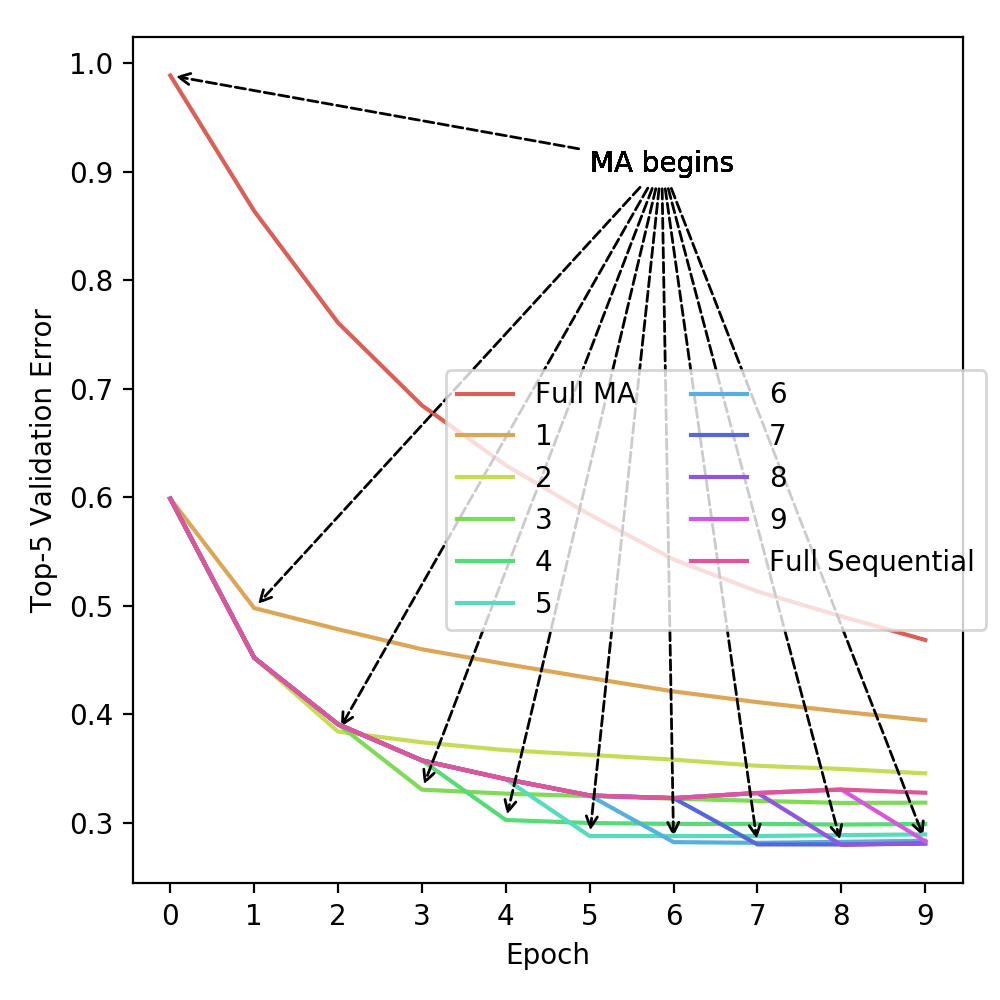

In [200]:
epochs = list(range(10))
plot_e2e = PlotterE2E()

for i in range(10):
    history = full_histories[i]
    anno = i if i != 0 else 'Full MA'
    history = 1 - np.array(history)
    plot_e2e.plot(epochs, history, anno)
    plt.annotate("MA begins", xy=(i, history[i]), xytext=(5, 0.9), arrowprops=dict(arrowstyle="->", linestyle='dashed'))
plot_e2e.plot(epochs, 1 - np.array(sequential_list), 'Full Sequential')
plot_e2e.conclude()

### Model size

#### ImageNet

In [50]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import TIME_FORMAT
import os
import datetime
import pandas as pd
import plotly.figure_factory as ff
from data_analytics import readlines
from collections import defaultdict
from matplotlib import pyplot as plt
import matplotlib
from data_analytics import save_fig
# font = {'family' : 'normal',
#         'size'   : 16}
# matplotlib.rc('font', **font)
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)

exp_names = [
    'udaf/model_size_s',
    'udaf/model_size_m',
    'udaf/model_size_l',
    'udaf/model_size_x',
    'ctq/model_size_s',
    'ctq/model_size_m',
    'ctq/model_size_l',
    'ctq/model_size_x'
]

methods = [
    'drill_down_udaf_ctq_model_size-udaf-s',
    'drill_down_udaf_ctq_model_size-udaf-m',
    'drill_down_udaf_ctq_model_size-udaf-l',
    'drill_down_udaf_ctq_model_size-udaf-x',
    'drill_down_udaf_ctq_model_size-ctq-s',
    'drill_down_udaf_ctq_model_size-ctq-m',
    'drill_down_udaf_ctq_model_size-ctq-l',
    'drill_down_udaf_ctq_model_size-ctq-x'
]

log_dirs_all = {}
for exp_name, method in zip(exp_names, methods):
    log_dirs_all[method] = {
        "log_root": '../logs',
        'gpu_logs': 'gpu_logs_july_august',
        'cpu_logs': 'cpu_logs_july_august',
        'network_logs': 'network_logs_september',
        'timestamp': '2020_09_10_22_42_31',
        'method': method,
        'exp_name': exp_name
    }

methods_comp = methods[:4] + methods[4:]
methods_comp[::2] = methods[:4]
methods_comp[1::2] = methods[4:]


la_list = {}
for method in methods_comp:
    log_dirs = log_dirs_all[method]
    la = LogAnalyzer(find_first=False, **log_dirs)
    print("Method: {}, runtime: {}".format(method, la.get_runtimes()[-1]))
    la_list[method] = la


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Method: drill_down_udaf_ctq_model_size-udaf-s, runtime: 5.816388888888889
Method: drill_down_udaf_ctq_model_size-ctq-s, runtime: 6.655277777777778
Method: drill_down_udaf_ctq_model_size-udaf-m, runtime: 7.5025
Method: drill_down_udaf_ctq_model_size-ctq-m, runtime: 8.691944444444445
Method: drill_down_udaf_ctq_model_size-udaf-l, runtime: 15.582222222222223
Method: drill_down_udaf_ctq_model_size-ctq-l, runtime: 15.706666666666667
Method: drill_down_udaf_ctq_model_size-udaf-x, runtime: 6.822222222222222
Method: drill_down_udaf_ctq_model_size-ctq-x, runtime: 7.44


In [53]:
plot_list = []
for msize in ['s', 'm', 'l']:
    for mode in ['ctq', 'udaf']:
        exp_name = 'drill_down_udaf_ctq_model_size-{}-{}'.format(mode, msize)
        df_events_grand = parse_all_events(la_list[exp_name])
        df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
        dict_time = dict(df_propotion_time.to_dict(orient='split')['data'])
        plot_time = {}
        for k, v in dict_time.items():
            if mode == 'ctq':
                mode_name = 'ctq_old'
            else:
                mode_name = mode
            scheme = semantics[mode_name][k]
            if scheme in plot_time:
                plot_time[scheme] += v
            else:
                plot_time[scheme] = v
        plot_time['msize'] = msize
        plot_time['mode'] = mode
        plot_list.append(plot_time)


df_plot = pd.DataFrame(plot_list)
df_plot['data_transmission'] = df_plot['data_transmission'] - df_plot.loc[(df_plot['mode']=='ctq') & (df_plot['msize'] == 's')]['data_transmission'][0]

df_plot['model_hopping'].fillna(0, inplace=True)
df_plot['data_transmission'] += df_plot['model_hopping']

df_plot[['initialization', 'exiting', 'data_transmission', 'idle', 'train_valid','model_hopping']]/= (3600*8*3)

In [54]:
df_plot

,initialization,exiting,data_transmission,idle,train_valid,msize,mode,model_hopping
0,0.059942,0.001204,0.000000,0.238507,1.258484,s,ctq,0.000000
1,0.060671,0.001505,0.089653,0.000868,1.225440,s,udaf,0.005463
2,0.070417,0.002199,0.006817,0.455706,1.746620,m,ctq,0.000000
3,0.071400,0.002049,0.123553,0.001065,1.738137,m,udaf,0.005266
4,0.210139,0.005810,0.020417,0.236713,4.139225,l,ctq,0.000000
5,0.223924,0.005521,0.223113,0.001655,4.136331,l,udaf,0.011076


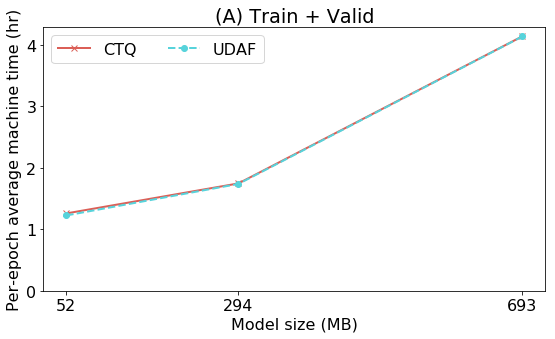

In [60]:
sizes = [52, 294, 693]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.set_xlabel('Model size (MB)')
ax.set_ylabel('Per-epoch average machine time (hr)')
ax.set_title('(A) Train + Valid')
df_plot_ctq = df_plot.loc[df_plot['mode'] == 'ctq']
ax.plot(sizes, df_plot_ctq['train_valid'], 'x-', label='CTQ', linewidth=2)
df_plot_udaf = df_plot.loc[df_plot['mode'] == 'udaf']
ax.plot(sizes, df_plot_udaf['train_valid'], 'o--', label='UDAF', linewidth=2)
ax.legend(ncol=2)
ax.set_ylim(ymin=0)
ax.set_xticks(sizes)
fig.tight_layout()


In [61]:
save_fig(fig, "model_size_sgd_cost")

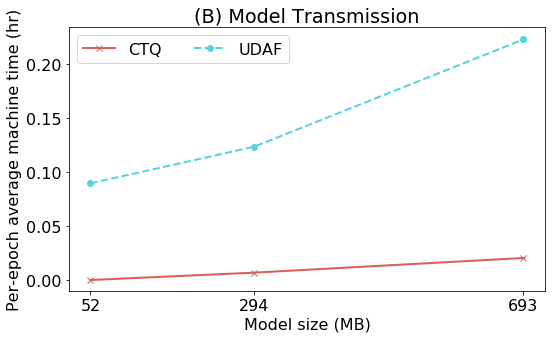

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.set_xlabel('Model size (MB)')
ax.set_ylabel('Per-epoch average machine time (hr)')
ax.set_title('(B) Model Transmission')
df_plot_ctq = df_plot.loc[df_plot['mode'] == 'ctq']
ax.plot(sizes, df_plot_ctq['data_transmission'], 'x-', label='CTQ', linewidth=2)
df_plot_udaf = df_plot.loc[df_plot['mode'] == 'udaf']
ax.plot(sizes, df_plot_udaf['data_transmission'], 'o--', label='UDAF', linewidth=2)
ax.legend(ncol=2)
ax.set_ylim(ymin=-.01)
ax.set_xticks(sizes)
fig.tight_layout()

In [63]:
save_fig(fig, "model_size_mop_cost")

#### Criteo

In [45]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import TIME_FORMAT
import os
import datetime
import pandas as pd
from data_analytics import readlines
from collections import defaultdict
from matplotlib import pyplot as plt
import matplotlib
from data_analytics import save_fig
# font = {'family' : 'normal',
#         'size'   : 16}
# matplotlib.rc('font', **font)
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)

method_trans = {
    'cerebro':'udaf',
    'cerebro-ctq':'ctq'
}
log_dirs_all = {
    'udaf':{
        "log_root": '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'network_logs': None,
        'timestamp': '2020_10_23_19_52_18',
        'method': 'cerebro',
        'exp_name': 'cerebro'
    },
    'ctq':{
        "log_root": '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'network_logs': None,
        'timestamp': '2020_10_24_02_59_23',
        'method': 'cerebro-ctq',
        'exp_name': 'cerebro-ctq'
    }
}


la_list = {}
for method, log_dirs in log_dirs_all.items():
    la = LogAnalyzer(find_first=False, **log_dirs)
    print("Method: {}, runtime: {}".format(method, la.get_runtimes()[-1]))
    la_list[method] = la

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Method: udaf, runtime: 7.032222222222222
Method: ctq, runtime: 8.265833333333333


In [49]:
plot_list = []
msize = 'confA'
for method, la in la_list.items():
    df_events_grand = parse_all_events(la)
    df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
    dict_time = dict(df_propotion_time.to_dict(orient='split')['data'])
    plot_time = {}
    for k, v in dict_time.items():
        mode_name = method
        scheme = semantics[mode_name][k]
        if scheme in plot_time:
            plot_time[scheme] += v
        else:
            plot_time[scheme] = v
    plot_time['msize'] = msize
    plot_time['mode'] = method
    plot_list.append(plot_time)

In [58]:
df_plot = pd.DataFrame(plot_list)

df_plot['model_hopping'] += (df_plot['data_transmission'] - df_plot.loc[(df_plot['mode']=='ctq')]['data_transmission'].iloc[0])
df_plot['data_transmission'] = df_plot.loc[(df_plot['mode']=='ctq')]['data_transmission'].iloc[0]


In [60]:


df_plot[['initialization', 'exiting', 'data_transmission', 'idle', 'train_valid','model_hopping']]/= (3600*8*3)

In [61]:
df_plot

,exiting,initialization,data_transmission,model_hopping,idle,train_valid,msize,mode
0,0.000486,0.002650,0.637859,0.081667,0.000752,1.617755,confA,udaf
1,0.000637,0.002639,0.637859,0.000255,0.427789,1.617396,confA,ctq


### Gantt Chart

In [80]:
# import dill
# from IPython.display import display
# import seaborn as sns
# colors = sns.color_palette("hls", 8)
# with open('../logs/run_logs/2020_09_10_22_42_31/ctq/model_size_x/jobs_info.pkl', 'rb') as f:
#     jobs_info = dill.load(f)

# df_list = []
# for job_key, job_info in jobs_info[1].items():
#     start_time = datetime.datetime.strptime(job_info['start_time'], TIME_FORMAT)
#     end_time = datetime.datetime.strptime(job_info['end_time'], TIME_FORMAT)
#     total_time = (end_time - start_time).total_seconds()
#     init_time = job_info['init_time']
#     train_time = job_info['train_time']
#     valid_time = job_info['valid_time']
#     df_list.append({
#         "start_time":start_time, 
#         'end_time':end_time, 
#         'total_time':total_time, 
#         'init_time':init_time, 'train_time':train_time, 
#         'valid_time':valid_time, 
#         'worker_number':int(job_key[1]),
#         'model_name':job_key[0]
#     })

# df_jobs = pd.DataFrame(df_list)
# df_jobs = df_jobs.sort_values('start_time').reset_index()




# with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
#     display(df_jobs)

# df_grand = df_jobs
# time_zero = df_grand['start_time'].min()
# time_max = df_grand['start_time'].max()

# for name in ['start_time', 'end_time']:
#     df_grand[name] = (df_grand[name] - time_zero).dt.total_seconds()/3600

# df_grand['Task'] = df_grand['worker_number']
# df_grand['Start'] = df_grand['start_time']
# df_grand['Finish'] = df_grand['end_time']

# model_names = list(df_grand['model_name'].unique())

# gannt chart
# df_plot = df_grand.sort_values('Task')
# font_size = 14

# start_point = df_plot['Start'].min()
# df_plot['Start']  = df_plot['Start'] - start_point
# df_plot['Finish']  = df_plot['Finish'] - start_point

# annots = []
# for i, row in df_plot.iterrows():
#     mid_point = ((row['Start'] + (row['Finish'] - row['Start'])/2))
#     obj = dict(
#         x=mid_point,
#         y=7 - int(row['worker_number']),
#         text="{}".format(model_names.index(row['model_name'])),
#         showarrow=False,
#         font=dict(color='white', size=int(font_size * 0.7)))
#     annots.append(obj)
    
    
    



# fig = ff.create_gantt(df_plot,
#                       colors=colors,
#                       index_col='model_name',
#                       show_colorbar=False,
#                       group_tasks=True, title=None)
# fig['layout']['xaxis'].update({'type': None})
# fig['layout']['xaxis']['title'] = 'time/hr'
# fig['layout']['xaxis']['tickfont']['size'] = font_size
# fig['layout']['yaxis']['tickfont']['size'] = font_size
# fig['layout']['xaxis']['title']['font']['size'] = font_size
# fig['layout']['font']['size'] = font_size
# fig['layout']['annotations'] = annots
# fig['layout']['plot_bgcolor'] = 'rgba(0,0,0,0)'

# W0 0     1 2 3
# W1 1 3 2   0
# W2 2 1 3     0
# W3 3 2 1 0
# 2(M - 1)

### Scalability

In [193]:
palette = sns.color_palette("hls", 5)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)

size = [1, 2, 4, 8]
times = {
#     'Cerebro-Spark': [26274.0, 10576.32, 5415.02, 3251.20],
    'Cerebro-Spark': [40177 - 1055, 19755 - 516, 10276 - 263, 5996 - 148],
    'MA': [64898, 32966, 17181, 9190],
    'UDAF': [65268, 32932, 17029, 8841],
    'CTQ': [64102, 32581, 18731, 10875],
    'DA-Cerebro': [118965-83525, 55665-37911, 29275-19046, 15007-9292],
    'DA_w_ETL': [118965, 55665, 29275, 15007]
}

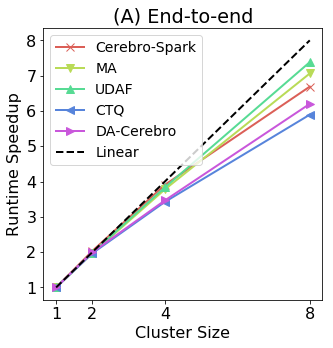

In [195]:


plot_scalability = PlotterBase(xlabel='Cluster Size', ylabel='Runtime Speedup', title='(A) End-to-end', set_ticks=True)


line_fmts = ['x-', 'v-', '^-', '<-', '>-' ]


for method, fmt in zip(methods, line_fmts):
    runtime = np.array(times[method])
    speedup = runtime[0] * 1.0 / runtime 
    plot_scalability.plot(size, speedup, fmt, label=method, markersize=8)
plot_scalability.plot(size, size, 'k--', label='Linear')
plot_scalability.ax.legend(fontsize=14)

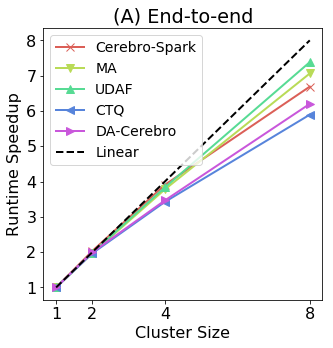

In [196]:
plot_scalability.fig

In [197]:
save_fig(plot_scalability.fig, 'scalability')

In [198]:
# Cerebro-Spark: 
# worker1: [par1, par2]
# worker2: [par3, par4]
# CTQ, MA, UDAF, DA:
# worker1: [par1*]
# worker2: [par2*]


In [290]:

size_exp_root_all = {
    'ctq':{1: '../logs/run_logs/scalability/2020_10_01_15_02_41/1/cerebro-ctq',
    2: '../logs/run_logs/scalability/2020_09_26_14_55_16/2/cerebro-ctq',
    4: '../logs/run_logs/scalability/2020_09_25_14_04_54/4/cerebro-ctq',
    8: '../logs/run_logs/scalability/2020_09_28_20_32_48/8/cerebro-ctq'},
    'ma':{1: '../logs/run_logs/scalability/2020_09_29_14_38_10/1/ma',
    2: '../logs/run_logs/scalability/2020_09_26_14_55_16/2/ma',
    4: '../logs/run_logs/scalability/2020_09_25_14_04_54/4/ma',
    8: '../logs/run_logs/scalability/2020_09_28_20_32_48/8/ma'},
    'udaf':{1: '../logs/run_logs/scalability/2020_09_29_14_38_10/1/cerebro',
    2: '../logs/run_logs/scalability/2020_09_26_14_55_16/2/cerebro',
    4: '../logs/run_logs/scalability/2020_09_25_14_04_54/4/cerebro',
    8: '../logs/run_logs/scalability/2020_09_28_20_32_48/8/cerebro'},
    'da':{1: '../logs/run_logs/scalability/2020_10_02_20_08_29/1/cerebro-da',
    2: '../logs/run_logs/scalability/2020_09_27_19_51_25/2/cerebro-da',
    4: '../logs/run_logs/scalability/2020_09_24_21_40_46/4/cerebro-da',
    8: '../logs/run_logs/scalability/2020_09_28_14_42_24/8/cerebro-da'},
    'spark':{1: '../logs/all_logs_gpu_2021feb/run_logs/2021_03_17_03_44_48/1/e2e_filesystem_cerebro_standalone',
    2: '../logs/all_logs_gpu_2021feb/run_logs/2021_03_17_17_53_23/2/e2e_filesystem_cerebro_standalone',
    4: '../logs/all_logs_gpu_2021feb/run_logs/2021_03_17_03_44_48/4/e2e_filesystem_cerebro_standalone',
    8: '../logs/all_logs_gpu_2021feb/run_logs/2021_03_17_17_53_23/8/e2e_filesystem_cerebro_standalone'},
}

size_segs_db = {
    1: [7],
    2: [0, 1],
    4: [0, 1, 2, 3],
    8: None,
}
size_segs_sa = {
    1: [0],
    2: [0, 1],
    4: [0, 1, 2, 3],
    8: None,
}
size_segs = {}
size_segs['udaf'] = size_segs_db
size_segs['ctq'] = size_segs_db
size_segs['ma'] = size_segs_db
size_segs['da'] = size_segs_sa
size_segs['spark'] = size_segs_sa

In [291]:
df_plot_dict = {}
dict_time_dict = defaultdict(dict)
for name, size_exp_root in size_exp_root_all.items():
    plot_list = []
    for size, exp_root in size_exp_root.items():
        print (size, exp_root)
        la = FakeLA(exp_root)
        segs = size_segs[name][size]
        method_name = 'standalone' if name in ['da', 'spark'] else name
        plot_time, dict_time = get_plot_time(la, segs, semantics[method_name], method_name)
        dict_time_dict[name][size] = dict_time
        plot_time['msize'] = size
        plot_list.append(plot_time)
    df_plot = pd.DataFrame(plot_list)
    df_plot_dict[name] = df_plot

1 ../logs/run_logs/scalability/2020_10_01_15_02_41/1/cerebro-ctq
2 ../logs/run_logs/scalability/2020_09_26_14_55_16/2/cerebro-ctq
4 ../logs/run_logs/scalability/2020_09_25_14_04_54/4/cerebro-ctq
8 ../logs/run_logs/scalability/2020_09_28_20_32_48/8/cerebro-ctq
1 ../logs/run_logs/scalability/2020_09_29_14_38_10/1/ma
2 ../logs/run_logs/scalability/2020_09_26_14_55_16/2/ma
4 ../logs/run_logs/scalability/2020_09_25_14_04_54/4/ma
8 ../logs/run_logs/scalability/2020_09_28_20_32_48/8/ma
1 ../logs/run_logs/scalability/2020_09_29_14_38_10/1/cerebro
2 ../logs/run_logs/scalability/2020_09_26_14_55_16/2/cerebro
4 ../logs/run_logs/scalability/2020_09_25_14_04_54/4/cerebro
8 ../logs/run_logs/scalability/2020_09_28_20_32_48/8/cerebro
1 ../logs/run_logs/scalability/2020_10_02_20_08_29/1/cerebro-da
2 ../logs/run_logs/scalability/2020_09_27_19_51_25/2/cerebro-da
4 ../logs/run_logs/scalability/2020_09_24_21_40_46/4/cerebro-da
8 ../logs/run_logs/scalability/2020_09_28_14_42_24/8/cerebro-da
1 ../logs/all_lo

In [292]:
df_events_grand = parse_all_events(la, segs, 'standalone')

df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1): 
    display(df_propotion_time)

,event,time
0,Between-PRELOAD_COMPLETED-TRAIN_LAUNCHED,28.0
1,Between-TRAIN_COMPLETED-TRAIN_LAUNCHED,4133.0
2,Between-TRAIN_COMPLETED-VALID_LAUNCHED,4920.0
3,Between-TRAIN_LAUNCHED-TRAIN_COMPLETED,36235.0
4,Between-VALID_COMPLETED-VALID_LAUNCHED,102.0
5,Between-VALID_LAUNCHED-VALID_COMPLETED,1155.0


In [293]:
df_plot_dict['udaf']['model_hopping'] += df_plot_dict['udaf']['data_transmission'] - df_plot_dict['ctq']['data_transmission']
df_plot_dict['ma']['model_hopping'] = df_plot_dict['ma']['data_transmission'] - df_plot_dict['ctq']['data_transmission']
df_plot_dict['udaf']['data_transmission'] = df_plot_dict['ctq']['data_transmission']
df_plot_dict['ma']['data_transmission'] = df_plot_dict['ctq']['data_transmission']
df_plot_dict['ctq']['train_valid']+= df_plot_dict['ctq']['initialization'] + df_plot_dict['ctq']['exiting']
df_plot_dict['ctq'] = df_plot_dict['ctq'][['data_transmission', 'model_hopping', 'train_valid', 'msize', 'idle']]
df_plot_dict['udaf']['train_valid']+= df_plot_dict['udaf']['initialization'] + df_plot_dict['udaf']['exiting']
df_plot_dict['udaf'] = df_plot_dict['udaf'][['data_transmission', 'model_hopping', 'train_valid', 'msize']]
df_plot_dict['ma']['train_valid']+= df_plot_dict['ma']['initialization'] + df_plot_dict['ma']['exiting']
df_plot_dict['ma'] = df_plot_dict['ma'][['data_transmission', 'model_hopping', 'train_valid', 'msize', 'merge']]
df_plot_dict['ma']
df_plot_dict['da']['model_hopping'] = df_plot_dict['ctq']['model_hopping']
df_plot_dict['da']['data_transmission'] = 0
df_plot_dict['da'] = df_plot_dict['da'][['data_transmission', 'model_hopping', 'train_valid', 'msize', 'idle']]
df_plot_dict['spark']['model_hopping'] = df_plot_dict['ctq']['model_hopping']
df_plot_dict['spark']['data_transmission'] = 0
df_plot_dict['spark'] = df_plot_dict['spark'][['data_transmission', 'model_hopping', 'train_valid', 'msize', 'idle']]

In [294]:
df_plot_dict['da']

,data_transmission,model_hopping,train_valid,msize,idle
0,0,4.0,35420.0,1,16.0
1,0,9.0,35424.0,2,602.0
2,0,8.0,36921.0,4,4774.0
3,0,23.0,40042.0,8,8064.0


In [295]:
df_plot_dict['spark']

,data_transmission,model_hopping,train_valid,msize,idle
0,0,4.0,38982.0,1,131.0
1,0,9.0,38096.0,2,344.0
2,0,8.0,37636.0,4,2360.0
3,0,23.0,37390.0,8,9183.0


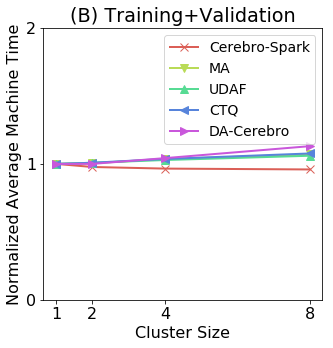

In [304]:
plot_scalability_drill = PlotterBase(xlabel='Cluster Size', ylabel='Normalized Average Machine Time', title='(B) Training+Validation', set_ticks=True)
methods_dict = {'Cerebro-Spark':'spark', 'MA':'ma', 'UDAF':'udaf', 'CTQ':'ctq', 'DA-Cerebro':'da'}


for method, fmt in zip(methods, line_fmts):
    df = df_plot_dict[methods_dict[method]]
    cluster_sizes = df['msize']
    train_valid = df['train_valid']
    plot_scalability_drill.plot(cluster_sizes, train_valid/train_valid[0], fmt, label=method, markersize=8)

plot_scalability_drill.ax.legend(fontsize=14)
plot_scalability_drill.ax.set_yticks(np.arange(0, 3))
save_fig(plot_scalability_drill.fig, 'scalability_drill_down_train')

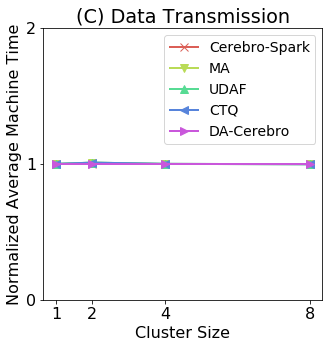

In [305]:
plot_scalability_drill = PlotterBase(xlabel='Cluster Size', ylabel='Normalized Average Machine Time', title='(C) Data Transmission', set_ticks=True)
methods_dict = {'Cerebro-Spark':'spark', 'MA':'ma', 'UDAF':'udaf', 'CTQ':'ctq', 'DA-Cerebro':'da'}


for method, fmt in zip(methods, line_fmts):
    df = df_plot_dict[methods_dict[method]]
    data_transmission = df['data_transmission']
    plot_scalability_drill.plot(cluster_sizes, (data_transmission/data_transmission[0]).fillna(1), fmt, label=method, markersize=8)

plot_scalability_drill.ax.set_yticks([0, 1, 2])

plot_scalability_drill.ax.legend(fontsize=14)
save_fig(plot_scalability_drill.fig, 'scalability_drill_down_data')




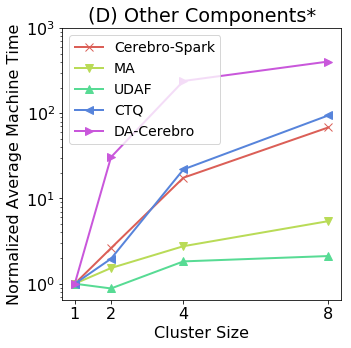

In [306]:
plot_scalability_drill = PlotterBase(xlabel='Cluster Size', ylabel='Normalized Average Machine Time', title='(D) Other Components*', set_ticks=True)


for method, fmt in zip(methods, line_fmts):
    df = df_plot_dict[methods_dict[method]]
    columns = df.columns
    columns = [column for column in columns if column not in ['msize', 'train_valid', 'data_transmission']]

    other = df[columns].sum(axis=1)
    plot_scalability_drill.plot(cluster_sizes, other/other[0], fmt, label=method, markersize=8)
plot_scalability_drill.ax.set_yscale('log')
plot_scalability_drill.ax.legend(fontsize=14)
plot_scalability_drill.ax.set_yticks([1, 10, 100, 1000])
save_fig(plot_scalability_drill.fig, 'scalability_drill_down_other')

### End-to-end Breakdown

#### Criteo

In [324]:
palette = ['#2B3A67', '#FFFD82', '#FF9B71', '#C14953']

size_exp_root_all = {
    'ctq':'../logs/run_logs/2020_10_19_18_33_55/cerebro-ctq',
    'ma':'../logs/run_logs/2020_10_21_13_58_50/ma',
    'udaf':'../logs/run_logs/2020_10_15_10_54_12/cerebro',
    'da':'../logs/run_logs/2020_10_14_03_31_04/cerebro-da',
    'standalone':'../logs/run_logs/2020_10_18_04_02_57/e2e_filesystem_cerebro_standalone'
}


df_plot_dict = {}
dict_time_dict = {}
plot_list = []
for name, exp_root in size_exp_root_all.items():
    print (name, exp_root)
    la = FakeLA(exp_root)
    method_name = 'standalone' if name in ['da', 'spark'] else name
    plot_time, dict_time = get_plot_time(la, None, semantics[method_name], method_name)
    dict_time_dict[name] = dict_time
    plot_time['name'] = name
    plot_list.append(plot_time)
        


ctq ../logs/run_logs/2020_10_19_18_33_55/cerebro-ctq
ma ../logs/run_logs/2020_10_21_13_58_50/ma
udaf ../logs/run_logs/2020_10_15_10_54_12/cerebro
da ../logs/run_logs/2020_10_14_03_31_04/cerebro-da
spark ../logs/run_logs/2020_10_18_04_02_57/e2e_filesystem_cerebro_standalone


In [333]:
df_plot.sum(axis=1)/3600/8

name
spark     0.000156
ma        0.000267
udaf      0.000431
ctq       0.000278
da        0.000151
ddp       0.000000
da-ddp    0.000000
dtype: float64

Text(0.5, 1.0, '(C) Per-epoch Runtimes Breakdown (Criteo)')

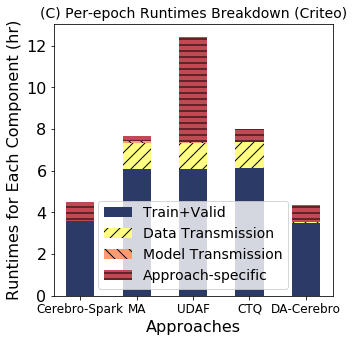

In [335]:
df_plot = pd.DataFrame(plot_list)

criteo_methods = list(methods)[:-2]
criteo_ordered_methods_indices = ordered_methods_indices[:-2]
df_plot = df_plot.fillna(0)

df_plot['train_valid'] += df_plot['exiting'] + df_plot['initialization']
df_plot = df_plot[[x for x in df_plot.columns if x not in ['exiting', 'initialization']]]

df_plot = df_plot.set_index('name')
df_plot.at['udaf', 'model_hopping'] += df_plot.loc['udaf']['data_transmission'] - df_plot.loc['ctq']['data_transmission']
# from model size tests

udaf_model_hopping = 0.081667 * 3600 * 8 
df_plot.at['udaf', 'idle'] = df_plot.loc['udaf']['model_hopping'] - udaf_model_hopping
df_plot.at['udaf', 'model_hopping'] = udaf_model_hopping
df_plot.at['ma', 'model_hopping'] = df_plot.loc['ma']['data_transmission'] - df_plot.loc['ctq']['data_transmission']
df_plot.at['udaf', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['ma', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['udaf', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['ma', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['spark', 'data_transmission'] = 118 * 8
df_plot.at['da', 'data_transmission'] = 118 * 8
df_plot.loc[['da', 'spark'], 'train_valid'] -= df_plot.loc[['da', 'spark'], 'data_transmission']


df_epochs = df_plot.loc[['da', 'spark']]
df_epochs[['idle', 'train_valid']]
df_plot.loc[['da', 'spark']] = df_epochs
df_plot.loc[['da', 'spark'], 'model_hopping'] = df_plot.loc['ctq', 'model_hopping']
df_plot.loc[['da', 'spark'], 'train_valid'] -= df_plot.loc[['da', 'spark'], 'model_hopping']
df_plot = (df_plot/8/3600)
df_plot = df_plot.reindex(criteo_ordered_methods_indices)

df_plot /= 5
title = '(C) Per-epoch Runtimes Breakdown (Criteo)'
plot_breakdown = PlotterBase(xlabel='Approaches', ylabel='Runtimes for Each Component (hr)', title=title, set_ticks=False)

index = range(len(criteo_methods))
fields = ['train_valid', 'data_transmission', 'model_hopping', 'method_specific']
names = ['Train+Valid', 'Data Transmission', 'Model Transmission', 'Approach-specific']
hatches = [None, '//', '\\\\', '--']

bar_width = 0.5


prev_bottom = pd.Series(0, index=criteo_ordered_methods_indices)
for field, name, color, hatch in zip(fields, names, palette, hatches):
    if field == 'method_specific':
        series_plot = df_plot['idle'] + df_plot['merge']
    else:
        series_plot = df_plot[field]
    
    plot_breakdown.ax.bar(index, series_plot, bar_width,color=color, label=name, bottom=prev_bottom, hatch=hatch)
    prev_bottom += series_plot
plot_breakdown.ax.set_xticks(index)
plot_breakdown.ax.set_xticklabels(methods, fontsize=12)
plot_breakdown.ax.set_yticks(range(14)[::2])
plot_breakdown.ax.legend(fontsize=14, loc='lower center')
plot_breakdown.ax.set_title(title, fontsize=14)

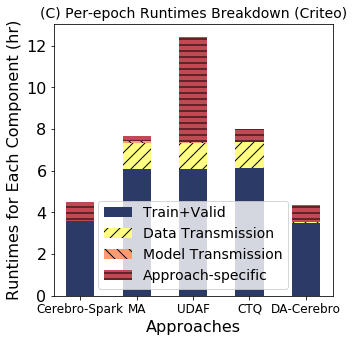

In [336]:
plot_breakdown.fig

In [337]:
save_fig(plot_breakdown.fig, 'e2e_breakdown_criteo')

#### ImageNet

In [309]:
palette = ['#2B3A67', '#FFFD82', '#FF9B71', '#C14953']

size_exp_root_all = {
    'ctq':'../logs/run_logs/2020_10_06_19_40_24/cerebro-ctq',
    'ma':'../logs/run_logs/2020_10_05_00_23_36/ma',
    'udaf':'../logs/run_logs/2020_10_05_00_23_36/cerebro',
    'da':'../logs/run_logs/2020_08_14_16_08_52/e2e_da_cerebro_standalone',
    'spark':'../logs/run_logs/2020_08_12_17_22_58/e2e_filesystem_cerebro_standalone',
    'ddp':'../logs/all_logs_gpu_2021feb/run_logs/2021_02_05_16_57_58/e2e_imagenet_pytorchddp',
    'da-ddp':'../logs/all_logs_gpu_2021feb/run_logs/2021_02_10_17_53_47/e2e_imagenet_pytorchddp_da'
    
}


df_plot_dict = {}
dict_time_dict = {}
plot_list = []
for name, exp_root in size_exp_root_all.items():
    print (name, exp_root)
    la = FakeLA(exp_root)
    if name in ['da', 'spark']:
        method_name = 'standalone'  
    elif name in ['da-ddp', 'ddp']:
        method_name = 'ddp'
    else:
        method_name = name
    debug = False
#     True if name == 'ddp' else False
    plot_time, dict_time = get_plot_time(la, None, semantics[method_name], method_name, debug=debug)
    dict_time_dict[name] = dict_time
    plot_time['name'] = name
    plot_list.append(plot_time)
        
df_plot = pd.DataFrame(plot_list)


df_plot = df_plot.fillna(0)

df_plot['train_valid'] += df_plot['exiting'] + df_plot['initialization']
df_plot = df_plot[[x for x in df_plot.columns if x not in ['exiting', 'initialization']]]

df_plot = df_plot.set_index('name')
df_ori_plot = df_plot

ctq ../logs/run_logs/2020_10_06_19_40_24/cerebro-ctq
ma ../logs/run_logs/2020_10_05_00_23_36/ma
udaf ../logs/run_logs/2020_10_05_00_23_36/cerebro
da ../logs/run_logs/2020_08_14_16_08_52/e2e_da_cerebro_standalone
spark ../logs/run_logs/2020_08_12_17_22_58/e2e_filesystem_cerebro_standalone
ddp ../logs/all_logs_gpu_2021feb/run_logs/2021_02_05_16_57_58/e2e_imagenet_pytorchddp
da-ddp ../logs/all_logs_gpu_2021feb/run_logs/2021_02_10_17_53_47/e2e_imagenet_pytorchddp_da


In [310]:
df_plot.sum(axis=1)/3600/8

name
ctq        4.143125
ma         4.406146
udaf       4.775799
da        23.011493
spark     22.865035
ddp        9.660868
da-ddp    10.013993
dtype: float64

In [311]:
df_plot = df_ori_plot.copy()
df_plot.at['udaf', 'model_hopping'] += df_plot.loc['udaf']['data_transmission'] - df_plot.loc['ctq']['data_transmission']
# from model size tests

udaf_model_hopping = (0.194919 + 0.123553) * 3600 * 8/2. 
df_plot.at['udaf', 'idle'] = df_plot.loc['udaf']['model_hopping'] - udaf_model_hopping
df_plot.at['udaf', 'model_hopping'] = udaf_model_hopping
df_plot.at['ma', 'model_hopping'] = df_plot.loc['ma']['data_transmission'] - df_plot.loc['ctq']['data_transmission']
df_plot.at['udaf', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['ma', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['spark', 'data_transmission'] = 32 * 8
df_plot.at['da', 'data_transmission'] = 32 * 8
df_plot.at['ddp', 'data_transmission'] /= 8
df_plot.at['da-ddp', 'data_transmission'] = df_plot.at['ddp', 'data_transmission']
df_plot.loc['da-ddp'] *= 8
df_plot.loc['ddp'] *= 8
df_plot.loc[['da', 'spark'], 'train_valid'] -= df_plot.loc[['da', 'spark'], 'data_transmission']


df_10epochs = df_plot.loc[['da', 'spark', 'ddp', 'da-ddp']]
df_10epochs[['idle', 'train_valid']] /= 10 
df_plot.loc[['da', 'spark', 'ddp', 'da-ddp']] = df_10epochs
df_plot.loc[['da', 'spark'], 'model_hopping'] = df_plot.loc['ctq', 'model_hopping']
df_plot.loc[['da', 'spark'], 'train_valid'] -= df_plot.loc[['da', 'spark'], 'model_hopping']
df_plot = (df_plot/8/3600)
df_plot = df_plot.reindex(ordered_methods_indices)

In [312]:
df_plot

,data_transmission,idle,model_hopping,train_valid,merge
name,,,,,
spark,0.008889,0.172872,0.001840,2.110903,0.000000
ma,1.050104,0.000000,0.072917,2.863576,0.419549
udaf,1.050104,0.676840,0.159236,2.889618,0.000000
ctq,1.050104,0.138854,0.001840,2.952326,0.000000
da,0.008889,0.187670,0.001840,2.110750,0.000000
ddp,0.025486,0.000000,0.000000,7.708306,0.000000
da-ddp,0.025486,0.000000,0.000000,7.768306,0.000000


In [313]:
df_plot.sum(axis = 1)

name
spark     2.294503
ma        4.406146
udaf      4.775799
ctq       4.143125
da        2.309149
ddp       7.733792
da-ddp    7.793792
dtype: float64

Text(0.5, 1.0, '(B) Per-epoch Runtimes Breakdown (ImageNet)')

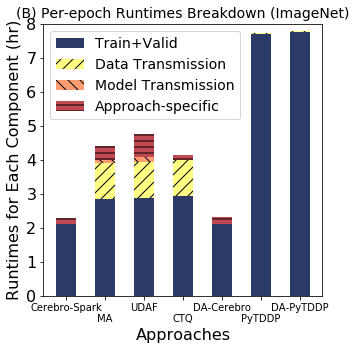

In [322]:
title = '(B) Per-epoch Runtimes Breakdown (ImageNet)'
plot_breakdown = PlotterBase(xlabel='Approaches', ylabel='Runtimes for Each Component (hr)', title=title, set_ticks=False)

index = range(len(methods))
fields = ['train_valid', 'data_transmission', 'model_hopping', 'method_specific']
names = ['Train+Valid', 'Data Transmission', 'Model Transmission', 'Approach-specific']
hatches = [None, '//', '\\\\', '--']

bar_width = 0.5


prev_bottom = pd.Series(0, index=ordered_methods_indices)
for field, name, color, hatch in zip(fields, names, palette, hatches):
    if field == 'method_specific':
        series_plot = df_plot['idle'] + df_plot['merge']
    else:
        series_plot = df_plot[field]
    
    plot_breakdown.ax.bar(index, series_plot, bar_width,color=color, label=name, bottom=prev_bottom, hatch=hatch)
    prev_bottom += series_plot
plot_breakdown.ax.set_xticks(index)
labels = plot_breakdown.ax.set_xticklabels(methods, fontsize=10)
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.04)
plot_breakdown.ax.set_yticks(range(9))
plot_breakdown.ax.legend(fontsize=14)
plot_breakdown.ax.set_title(title, fontsize=14)




In [323]:
save_fig(plot_breakdown.fig, 'e2e_breakdown')

In [408]:
series_plot

name
spark    0.172872
ma       0.419549
udaf     0.676840
ctq      0.138854
da       0.187670
dtype: float64

### Hetero test

In [523]:
# poll from db
log_dirs_all = {
    'udaf-8':{
        'timestamp': '2021_03_18_03_45_34',
        'timestamp_db':'2021_03_18_03_46_20',
        'method': 'udaf',
        'exp_name': 'cerebro-udaf_drill_down_hetro_8'
    },
    'udaf-6':{
        'timestamp': '2021_03_21_18_29_53',
        'timestamp_db':'2021_03_21_18_30_49',
        'method': 'udaf',
        'exp_name': 'cerebro-udaf_drill_down_hetro_6'
    },
    'udaf-4':{
        'timestamp': '2021_03_19_02_06_09',
        'timestamp_db':'2021_03_19_02_06_55',
        'method': 'udaf',
        'exp_name': 'cerebro-udaf_drill_down_hetro_8'
    },
    'udaf-2':{
        'timestamp': '2021_03_19_21_03_27',
        'timestamp_db':'2021_03_19_21_04_13',
        'method': 'udaf',
        'exp_name': 'cerebro-udaf_drill_down_hetro_2'
    },
    'ctq-8':{
        'timestamp': '2021_03_22_20_34_14',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq_drill_down_hetro'
    },
    'ctq-6':{
        'timestamp': '2021_03_22_23_57_08',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq_drill_down_hetro'
    },
    'ctq-4':{
        'timestamp': '2021_03_23_04_06_43',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq_drill_down_hetro'
    },
    'ctq-2':{
        'timestamp': '2021_03_23_09_26_42',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq_drill_down_hetro'
    }

    
}
for method, method_dict in log_dirs_all.items():
    method_dict['network_logs'] = 'network_logs'
    method_dict['cpu_logs'] = 'cpu_logs'
    method_dict['gpu_logs'] = 'gpu_logs'
    method_dict['disk_logs'] = 'disk_logs'
    method_dict['method'] = method
    method_dict['log_root'] = '../logs/all_logs_gpu_2021feb'

In [524]:
total_times = {}
for method, log_dirs in log_dirs_all.items():
    print(method)
    find_first = True
    la = LogAnalyzer(find_first=find_first, **log_dirs)
    la_dict[method] = la
    df_grand, x, y = la.get_learning_curve()
    total_times[method] = la.report_runtimes()

udaf-8
Method: udaf
Total time: 8.990555555555556 hrs
udaf-6
Method: udaf
Total time: 9.912777777777778 hrs
udaf-4
Method: udaf
Total time: 11.585555555555555 hrs
udaf-2
Method: udaf
Total time: 14.247222222222222 hrs
ctq-8
Method: ctq
Total time: 3.2944444444444443 hrs
ctq-6
Method: ctq
Total time: 4.073055555555555 hrs
ctq-4
Method: ctq
Total time: 5.245833333333334 hrs
ctq-2
Method: ctq
Total time: 9.303055555555556 hrs


In [525]:
speedups = []
for size in [2, 4, 6, 8]:
    udaf_method = 'udaf-{}'.format(size)
    ctq_method = 'ctq-{}'.format(size)
    udaf_time, ctq_time = total_times[udaf_method], total_times[ctq_method]
    speedup = udaf_time/ctq_time
    
    print("SIZE: {}, UDAF time: {}, CTQ time: {}, SPEEDUP: {}".format(size, udaf_time, ctq_time, speedup))
    speedups.append(speedup)

SIZE: 2, UDAF time: 14.247222222222222, CTQ time: 9.303055555555556, SPEEDUP: 1.531456212116688
SIZE: 4, UDAF time: 11.585555555555555, CTQ time: 5.245833333333334, SPEEDUP: 2.208525284617421
SIZE: 6, UDAF time: 9.912777777777778, CTQ time: 4.073055555555555, SPEEDUP: 2.433744799836323
SIZE: 8, UDAF time: 8.990555555555556, CTQ time: 3.2944444444444443, SPEEDUP: 2.729005059021923


In [526]:
speedups

[1.531456212116688, 2.208525284617421, 2.433744799836323, 2.729005059021923]